# Previsão de Sucesso de Startups 

Este notebook apresenta todo o fluxo: exploração dos dados, tratamento/limpeza, engenharia de features, seleção e ajuste de modelos (com GridSearch), avaliação e geração do arquivo de submissão (`submission.csv`).

- Bibliotecas permitidas: Numpy, Pandas, Scikit-learn. Para visualização: Matplotlib e Seaborn.
- Métrica principal: acurácia (também reportamos precisão, recall e F1-score).


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Configurações gerais
sns.set(style="whitegrid", context="notebook")
plt.rcParams["figure.figsize"] = (8, 5)

# Carregar dados
train_path = "train.csv"
test_path = "test.csv"

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

print("Train shape:", df_train.shape)
print("Test shape:", df_test.shape)
df_train.head()


Train shape: (646, 33)
Test shape: (277, 32)


,id,age_first_funding_year,age_last_funding_year,age_first_milestone_year,age_last_milestone_year,relationships,funding_rounds,funding_total_usd,milestones,is_CA,...,is_consulting,is_othercategory,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,labels
0,719,10.42,13.09,8.98,12.72,4,3,4087500,3,1,...,0,0,1,1,0,0,0,0,1.0,0
1,429,3.79,3.79,NaN,NaN,21,1,45000000,0,0,...,0,0,0,0,0,1,0,0,1.0,1
2,178,0.71,2.28,1.95,2.28,5,2,5200000,2,1,...,0,1,1,0,1,0,0,0,1.0,0
3,197,3.00,5.00,9.62,10.39,16,2,14500000,2,0,...,0,0,0,1,0,1,0,0,2.0,1
4,444,0.66,5.88,6.21,8.61,29,5,70000000,4,1,...,0,0,0,0,1,1,1,1,2.8,1


In [4]:
## 1. Análise Exploratória de Dados (EDA)

### 1.1 Configuração de Estilo


In [5]:
# Estilo e paleta para gráficos
sns.set_theme(style="whitegrid", palette="Set2")
plt.rcParams["figure.figsize"] = (10, 6)
CUSTOM_PALETTE = sns.color_palette("Set2")


### 1.2 Separação de Features e Target


In [6]:
# Separar features e alvo
TARGET = "labels"
ID = "id"

X = df_train.drop(columns=[TARGET])
y = df_train[TARGET]

# Identificar colunas numéricas e categóricas
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

print(f"Total de features: {X.shape[1]}")
print(f"Features numéricas: {len(num_cols)}")
print(f"Features categóricas: {len(cat_cols)}")
print(f"\nColunas categóricas: {cat_cols}")


Total de features: 32
Features numéricas: 31
Features categóricas: 1

Colunas categóricas: ['category_code']


### 1.3 Análise da Variável Alvo


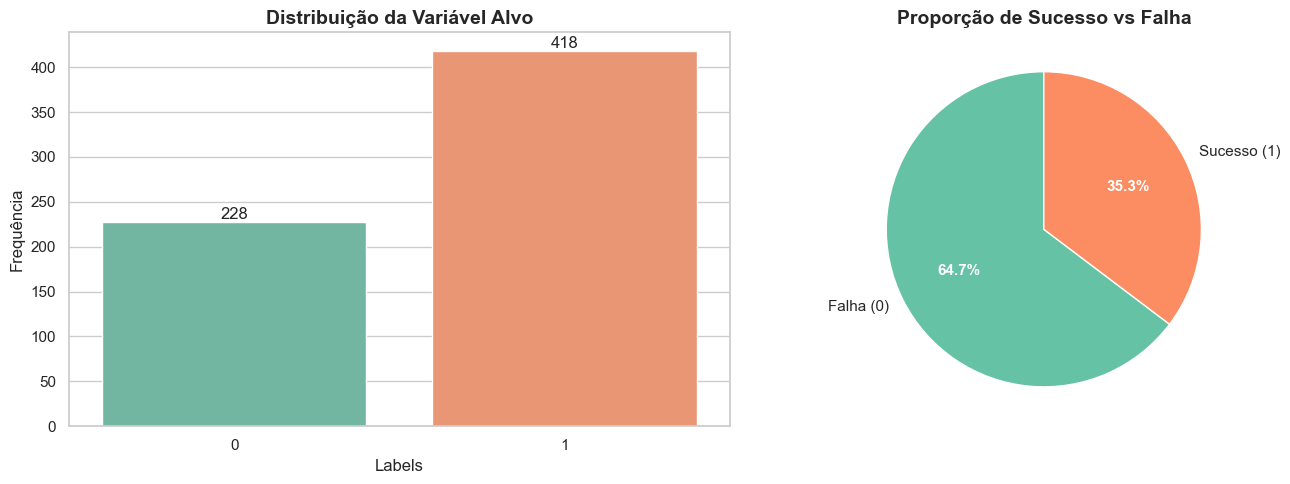

Total de registros: 646
Sucessos (1): 418 (64.71%)
Falhas (0): 228 (35.29%)
Proporção Sucesso/Falha: 1.83:1


In [7]:
# Distribuição da variável alvo
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Countplot
sns.countplot(x=y, palette="Set2", ax=ax[0], hue=y, legend=False)
ax[0].set_title('Distribuição da Variável Alvo', fontsize=14, fontweight='bold')
ax[0].set_xlabel('Labels', fontsize=12)
ax[0].set_ylabel('Frequência', fontsize=12)
for container in ax[0].containers:
    ax[0].bar_label(container)

# Proporções
value_counts = y.value_counts()
colors = sns.color_palette("Set2", n_colors=len(value_counts))
wedges, texts, autotexts = ax[1].pie(value_counts, labels=['Falha (0)', 'Sucesso (1)'], 
                                       autopct='%1.1f%%', colors=colors, startangle=90)
ax[1].set_title('Proporção de Sucesso vs Falha', fontsize=14, fontweight='bold')
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(11)

plt.tight_layout()
plt.show()

print(f"Total de registros: {len(y)}")
print(f"Sucessos (1): {value_counts[1]} ({value_counts[1]/len(y)*100:.2f}%)")
print(f"Falhas (0): {value_counts[0]} ({value_counts[0]/len(y)*100:.2f}%)")
print(f"Proporção Sucesso/Falha: {value_counts[1]/value_counts[0]:.2f}:1")


### 1.4 Análise de Valores Ausentes


ANÁLISE DE VALORES AUSENTES
                 Feature  Missing_Count  Missing_Percent
age_first_milestone_year            138        21.362229
 age_last_milestone_year            111        17.182663
  age_first_funding_year             35         5.417957
   age_last_funding_year              9         1.393189

Total de features com valores ausentes: 4
Total de features sem valores ausentes: 28


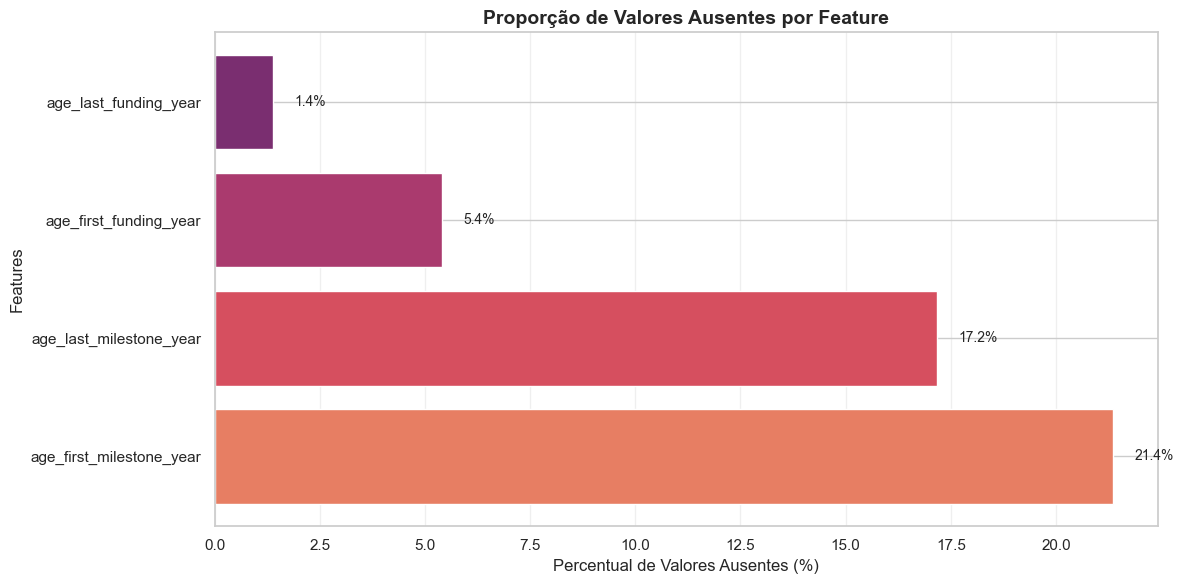

In [8]:
# Análise detalhada de valores ausentes
missing_data = pd.DataFrame({
    'Feature': X.columns,
    'Missing_Count': X.isna().sum(),
    'Missing_Percent': X.isna().mean() * 100
})
missing_data = missing_data[missing_data['Missing_Count'] > 0].sort_values('Missing_Percent', ascending=False)

print("=" * 60)
print("ANÁLISE DE VALORES AUSENTES")
print("=" * 60)
print(missing_data.to_string(index=False))
print(f"\nTotal de features com valores ausentes: {len(missing_data)}")
print(f"Total de features sem valores ausentes: {X.shape[1] - len(missing_data)}")

# Visualização de missing values
if len(missing_data) > 0:
    fig, ax = plt.subplots(figsize=(12, 6))
    colors = sns.color_palette("flare", n_colors=len(missing_data))
    bars = ax.barh(missing_data['Feature'], missing_data['Missing_Percent'], color=colors)
    ax.set_xlabel('Percentual de Valores Ausentes (%)', fontsize=12)
    ax.set_ylabel('Features', fontsize=12)
    ax.set_title('Proporção de Valores Ausentes por Feature', fontsize=14, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    
    # Adicionar valores nas barras
    for i, (bar, val) in enumerate(zip(bars, missing_data['Missing_Percent'])):
        ax.text(val + 0.5, bar.get_y() + bar.get_height()/2, f'{val:.1f}%', 
                va='center', fontsize=10)
    
    plt.tight_layout()
    plt.show()


### 1.5 Estatísticas Descritivas das Features Numéricas


In [9]:
# Estatísticas descritivas completas
desc_stats = X[num_cols].describe().T
desc_stats['missing%'] = X[num_cols].isna().mean() * 100
desc_stats['skewness'] = X[num_cols].skew()
desc_stats['kurtosis'] = X[num_cols].kurtosis()

print("=" * 100)
print("ESTATÍSTICAS DESCRITIVAS DAS FEATURES NUMÉRICAS")
print("=" * 100)
print(desc_stats.to_string())

# Identificar features com alta assimetria (|skewness| > 1)
high_skew = desc_stats[abs(desc_stats['skewness']) > 1].sort_values('skewness', ascending=False)
if len(high_skew) > 0:
    print(f"\n\nFeatures com alta assimetria (|skewness| > 1): {len(high_skew)}")
    print(high_skew[['mean', 'std', 'skewness', 'kurtosis']].to_string())


ESTATÍSTICAS DESCRITIVAS DAS FEATURES NUMÉRICAS
                          count          mean           std      min          25%           50%           75%           max   missing%   skewness    kurtosis
id                        646.0  4.615774e+02  2.648595e+02      1.0      233.250  4.595000e+02  6.925000e+02  9.230000e+02   0.000000   0.001708   -1.180267
age_first_funding_year    611.0  2.341718e+00  2.468275e+00      0.0        0.680  1.650000e+00  3.600000e+00  2.190000e+01   5.417957   2.682061   13.567819
age_last_funding_year     637.0  4.037724e+00  2.950923e+00      0.0        1.870  3.610000e+00  5.590000e+00  2.190000e+01   1.393189   1.309560    3.635086
age_first_milestone_year  508.0  3.352657e+00  2.866952e+00      0.0        1.185  2.785000e+00  4.935000e+00  2.468000e+01  21.362229   1.785788    6.952147
age_last_milestone_year   535.0  4.944729e+00  3.213319e+00      0.0        2.540  4.620000e+00  6.880000e+00  2.468000e+01  17.182663   0.994136    2.632077
rela

### 1.6 Distribuições das Features Numéricas Principais


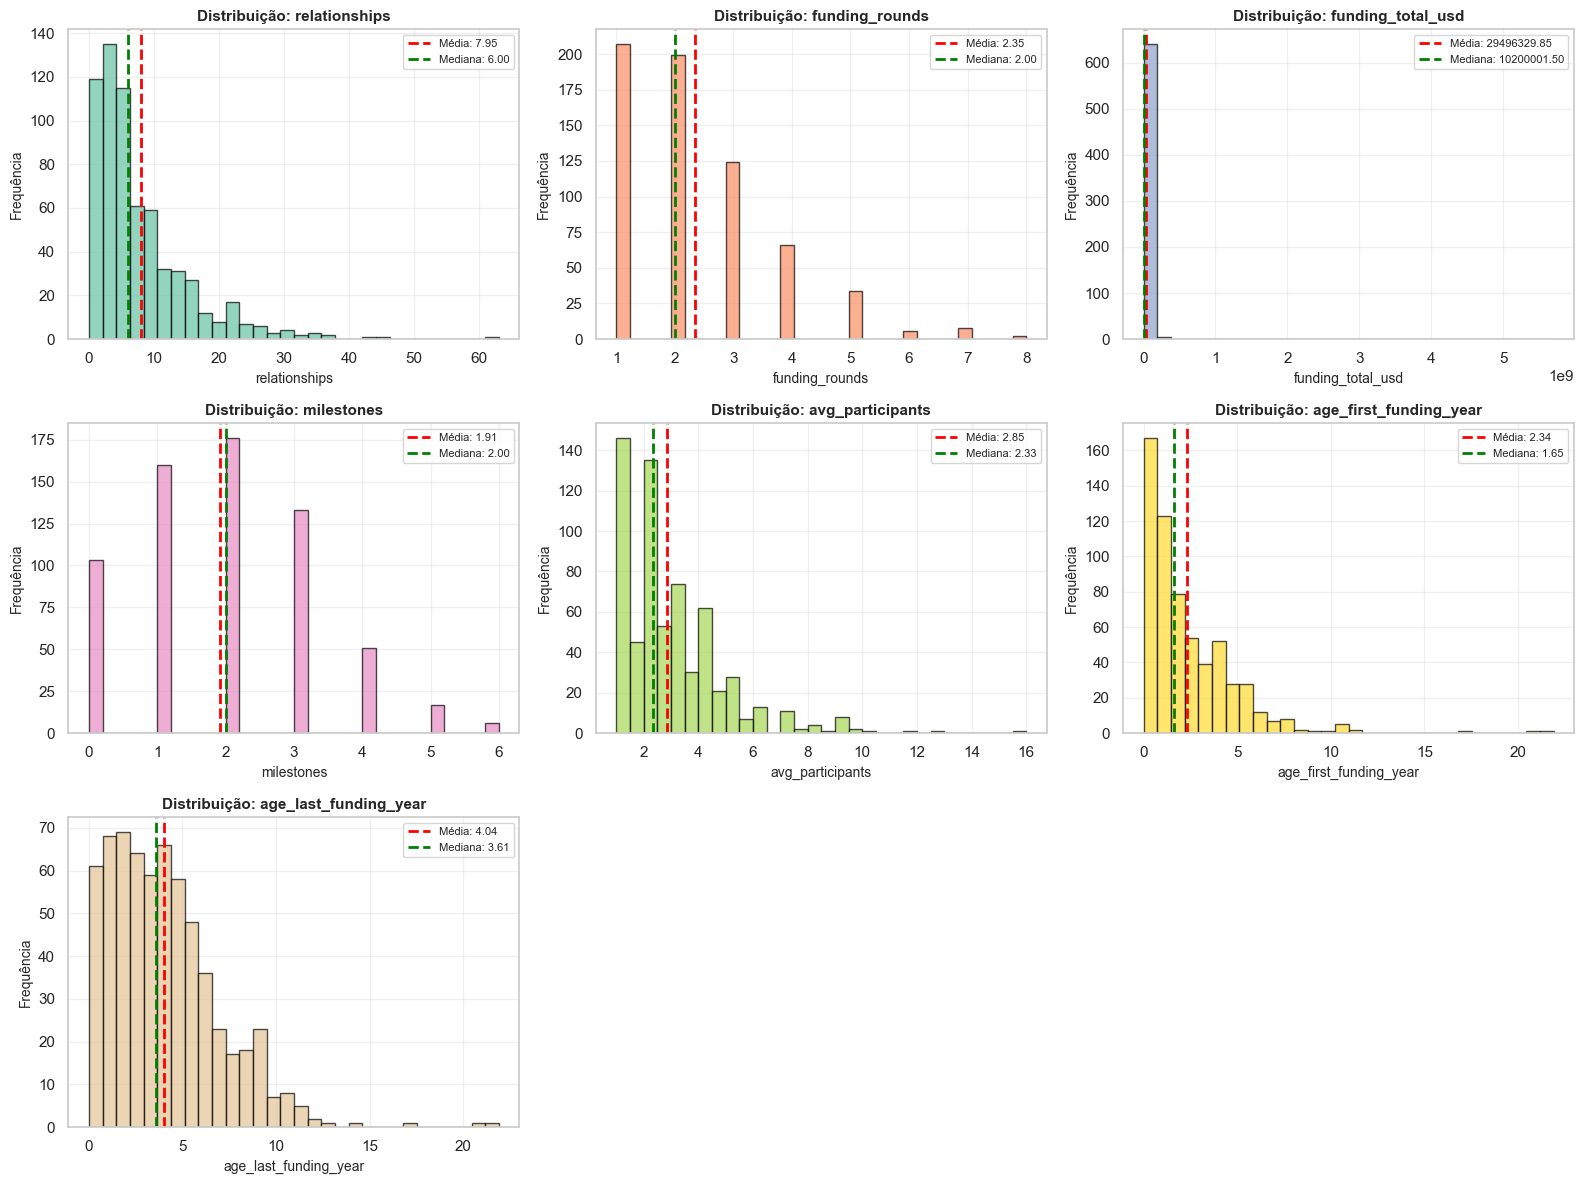

In [10]:
# Visualizar distribuições das principais features numéricas
main_features = ['relationships', 'funding_rounds', 'funding_total_usd', 'milestones', 
                 'avg_participants', 'age_first_funding_year', 'age_last_funding_year']

fig, axes = plt.subplots(3, 3, figsize=(16, 12))
axes = axes.ravel()

for idx, col in enumerate(main_features):
    if col in X.columns:
        # Histogram com KDE
        axes[idx].hist(X[col].dropna(), bins=30, alpha=0.7, color=CUSTOM_PALETTE[idx % len(CUSTOM_PALETTE)], edgecolor='black')
        axes[idx].set_title(f'Distribuição: {col}', fontsize=11, fontweight='bold')
        axes[idx].set_xlabel(col, fontsize=10)
        axes[idx].set_ylabel('Frequência', fontsize=10)
        axes[idx].grid(alpha=0.3)
        
        # Adicionar estatísticas
        mean_val = X[col].mean()
        median_val = X[col].median()
        axes[idx].axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Média: {mean_val:.2f}')
        axes[idx].axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Mediana: {median_val:.2f}')
        axes[idx].legend(fontsize=8)

# Remover eixos extras
for idx in range(len(main_features), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()


### 1.7 Boxplots para Identificação de Outliers


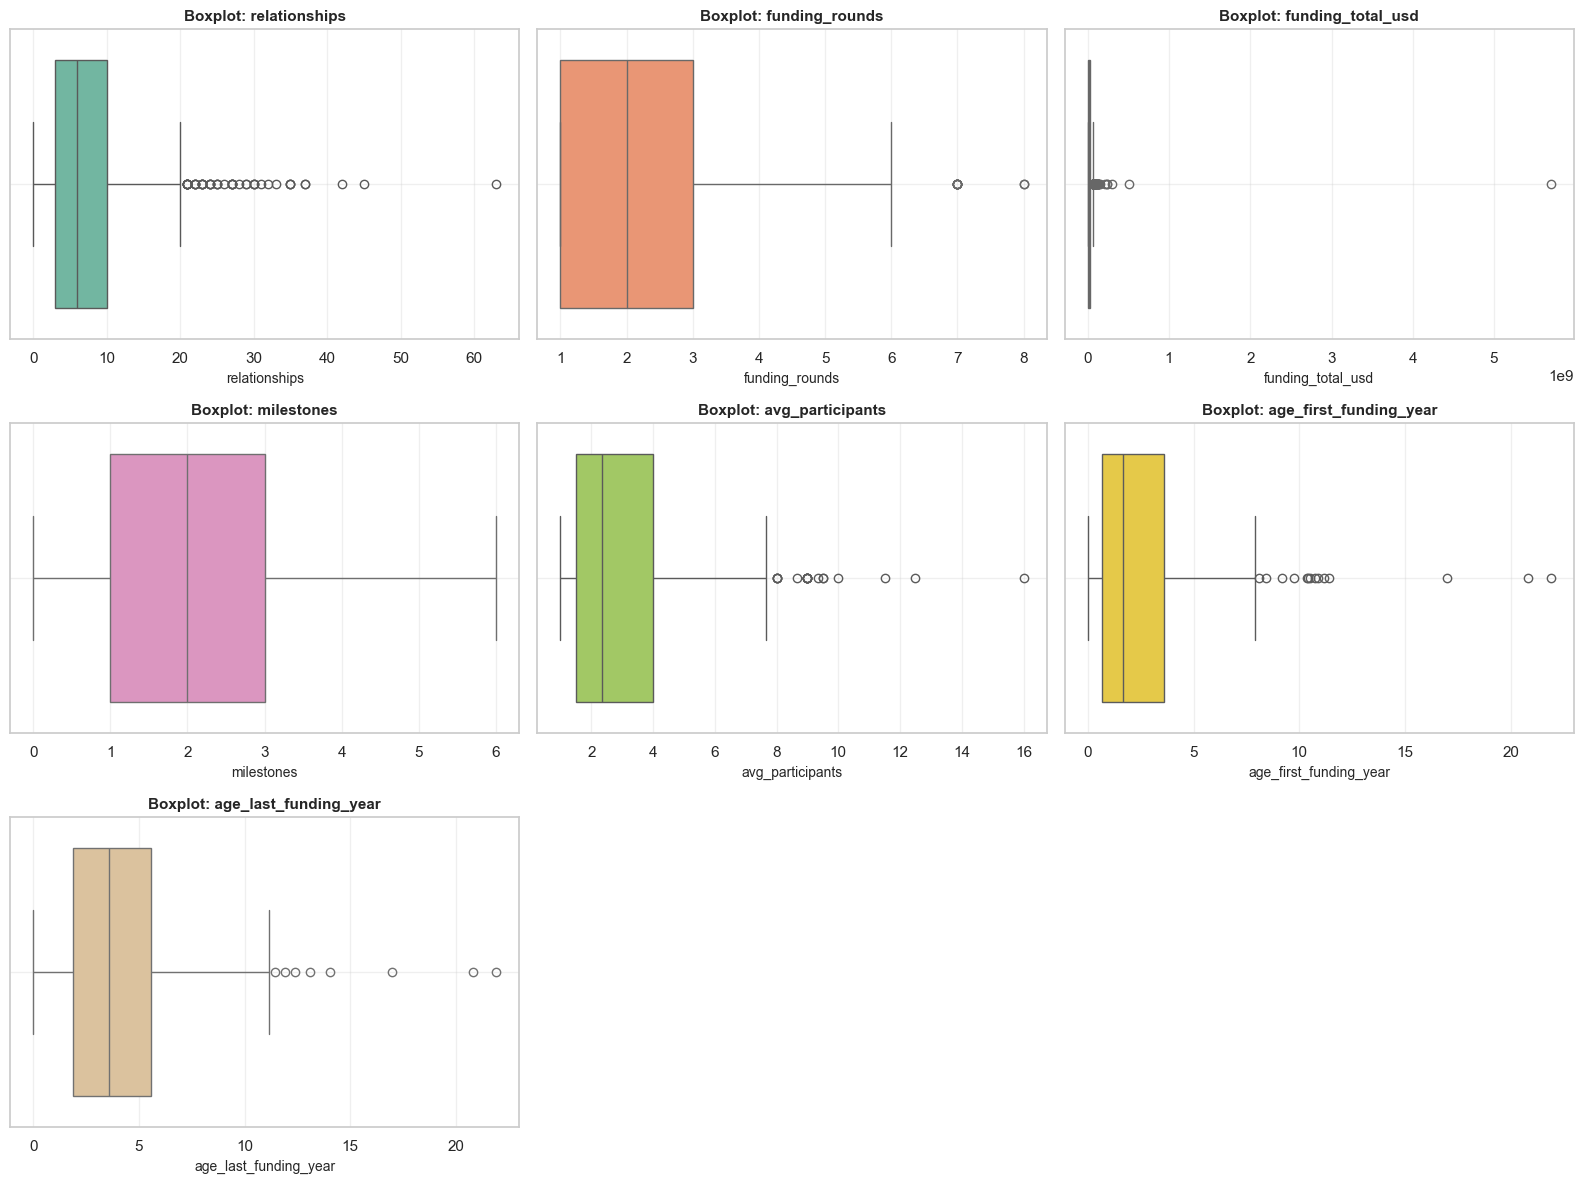


ANÁLISE DE OUTLIERS (Método IQR)
relationships                 :   47 outliers ( 7.28%)
funding_rounds                :   10 outliers ( 1.55%)
funding_total_usd             :   50 outliers ( 7.74%)
milestones                    :    0 outliers ( 0.00%)
avg_participants              :   19 outliers ( 2.94%)
age_first_funding_year        :   14 outliers ( 2.29%)
age_last_funding_year         :    8 outliers ( 1.26%)


In [11]:
# Boxplots para identificar outliers
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
axes = axes.ravel()

for idx, col in enumerate(main_features):
    if col in X.columns:
        sns.boxplot(x=X[col], ax=axes[idx], color=CUSTOM_PALETTE[idx % len(CUSTOM_PALETTE)])
        axes[idx].set_title(f'Boxplot: {col}', fontsize=11, fontweight='bold')
        axes[idx].set_xlabel(col, fontsize=10)
        axes[idx].grid(alpha=0.3)

# Remover eixos extras
for idx in range(len(main_features), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

# Contar outliers usando método IQR
print("\n" + "=" * 60)
print("ANÁLISE DE OUTLIERS (Método IQR)")
print("=" * 60)
for col in main_features:
    if col in X.columns:
        Q1 = X[col].quantile(0.25)
        Q3 = X[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = X[(X[col] < lower_bound) | (X[col] > upper_bound)][col]
        outlier_pct = (len(outliers) / len(X[col].dropna())) * 100
        print(f"{col:30s}: {len(outliers):4d} outliers ({outlier_pct:5.2f}%)")


### 1.8 Matriz de Correlação das Features Numéricas


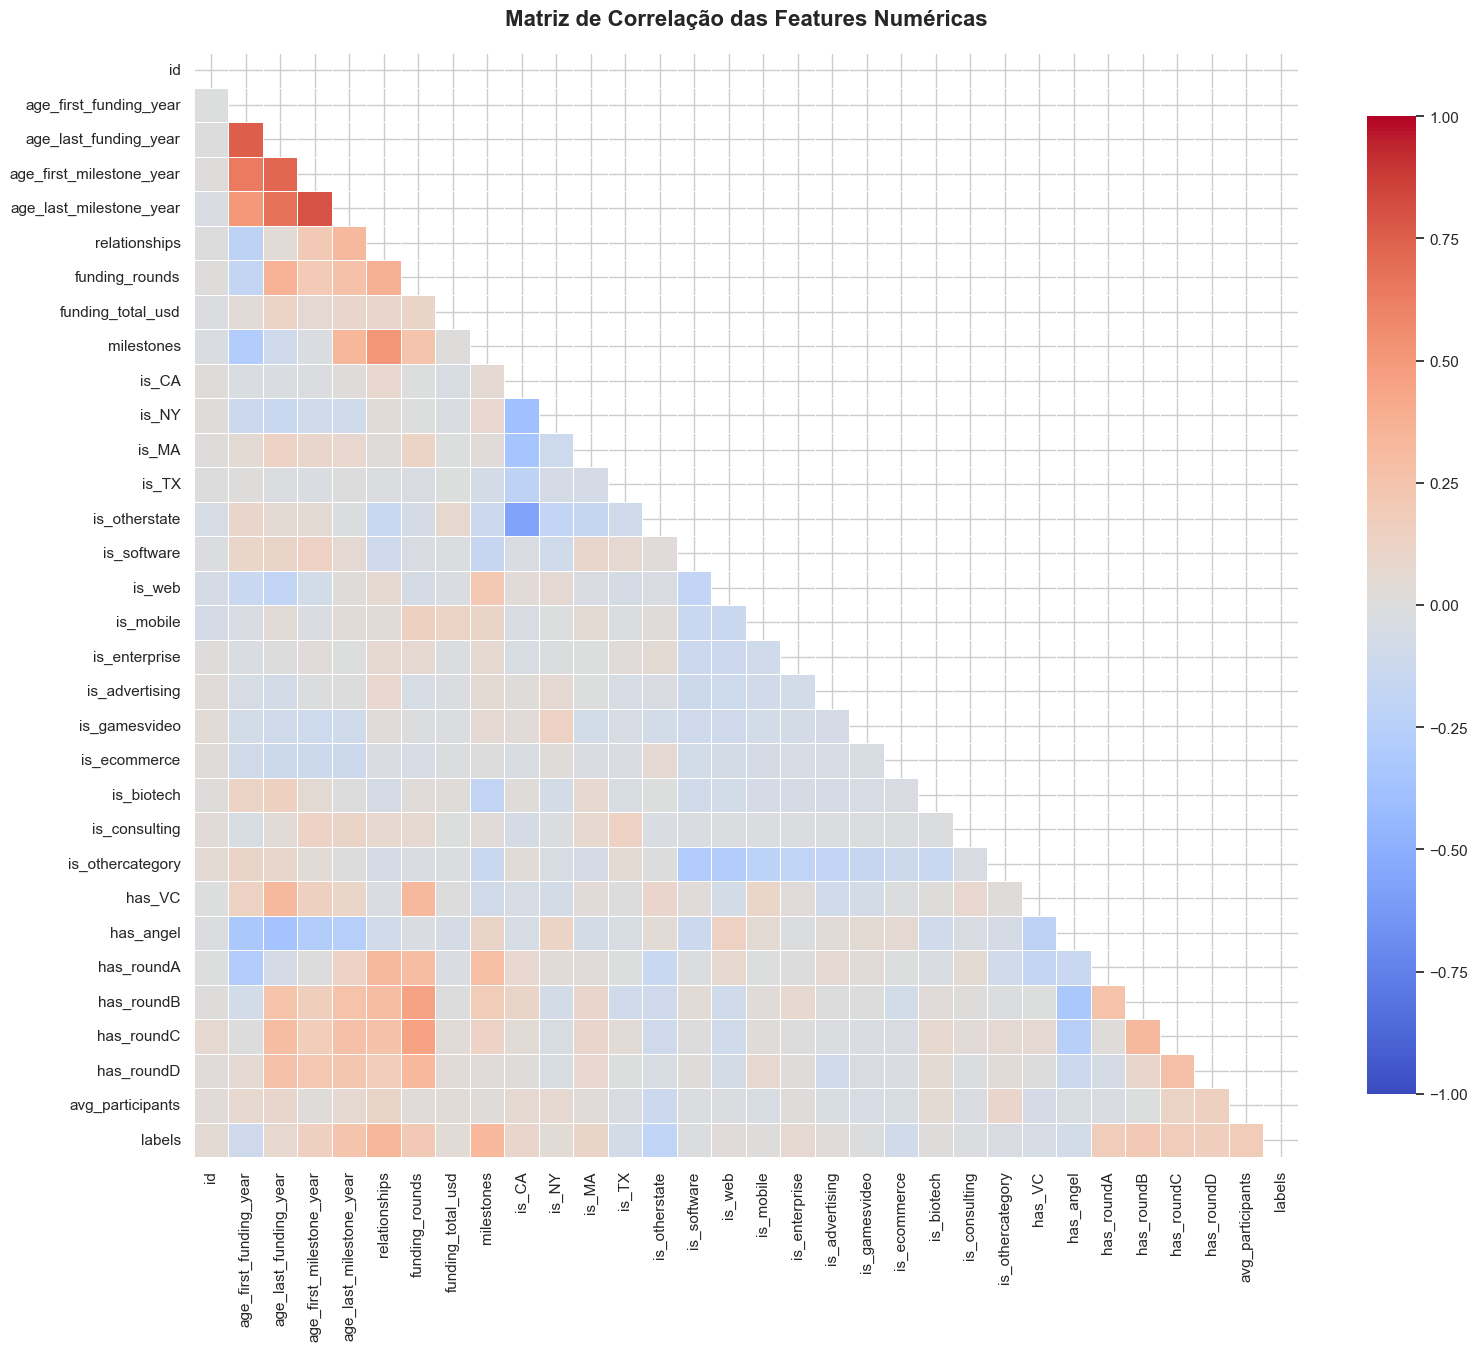


CORRELAÇÕES FORTES ENTRE FEATURES (|r| > 0.5)
               Feature 1                Feature 2  Correlação
age_first_milestone_year  age_last_milestone_year    0.803317
  age_first_funding_year    age_last_funding_year    0.752418
   age_last_funding_year age_first_milestone_year    0.725360
   age_last_funding_year  age_last_milestone_year    0.677464
  age_first_funding_year age_first_milestone_year    0.638612
                   is_CA            is_otherstate   -0.566811
           relationships               milestones    0.519467
  age_first_funding_year  age_last_milestone_year    0.504715


In [12]:
# Matriz de correlação completa
correlation_matrix = df_train[num_cols + [TARGET]].corr()

# Visualização da matriz de correlação
fig, ax = plt.subplots(figsize=(16, 14))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))  # Máscara para triângulo superior
sns.heatmap(correlation_matrix, mask=mask, annot=False, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=0.5, cbar_kws={"shrink": 0.8}, ax=ax,
            vmin=-1, vmax=1)
ax.set_title('Matriz de Correlação das Features Numéricas', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Encontrar correlações fortes (> 0.5 ou < -0.5) excluindo a diagonal
print("\n" + "=" * 80)
print("CORRELAÇÕES FORTES ENTRE FEATURES (|r| > 0.5)")
print("=" * 80)
corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) > 0.5:
            corr_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j], corr_val))

corr_pairs_df = pd.DataFrame(corr_pairs, columns=['Feature 1', 'Feature 2', 'Correlação'])
corr_pairs_df = corr_pairs_df.sort_values('Correlação', key=abs, ascending=False)
print(corr_pairs_df.to_string(index=False))


### 1.9 Correlação com a Variável Alvo


CORRELAÇÃO DAS FEATURES COM O TARGET (labels)

Top 15 Correlações Positivas:
relationships               0.342841
milestones                  0.335149
age_last_milestone_year     0.257261
has_roundB                  0.214299
funding_rounds              0.212760
avg_participants            0.194482
has_roundC                  0.172943
has_roundA                  0.171953
has_roundD                  0.166680
age_first_milestone_year    0.156837
is_MA                       0.116638
is_CA                       0.101427
age_last_funding_year       0.074744
is_enterprise               0.067350
id                          0.050312

Top 15 Correlações Negativas:
is_NY                     0.042035
is_web                    0.029337
is_advertising            0.023952
is_biotech                0.013831
is_mobile                 0.010135
is_software              -0.008263
is_gamesvideo            -0.013120
is_consulting            -0.017149
is_othercategory         -0.038491
has_VC                

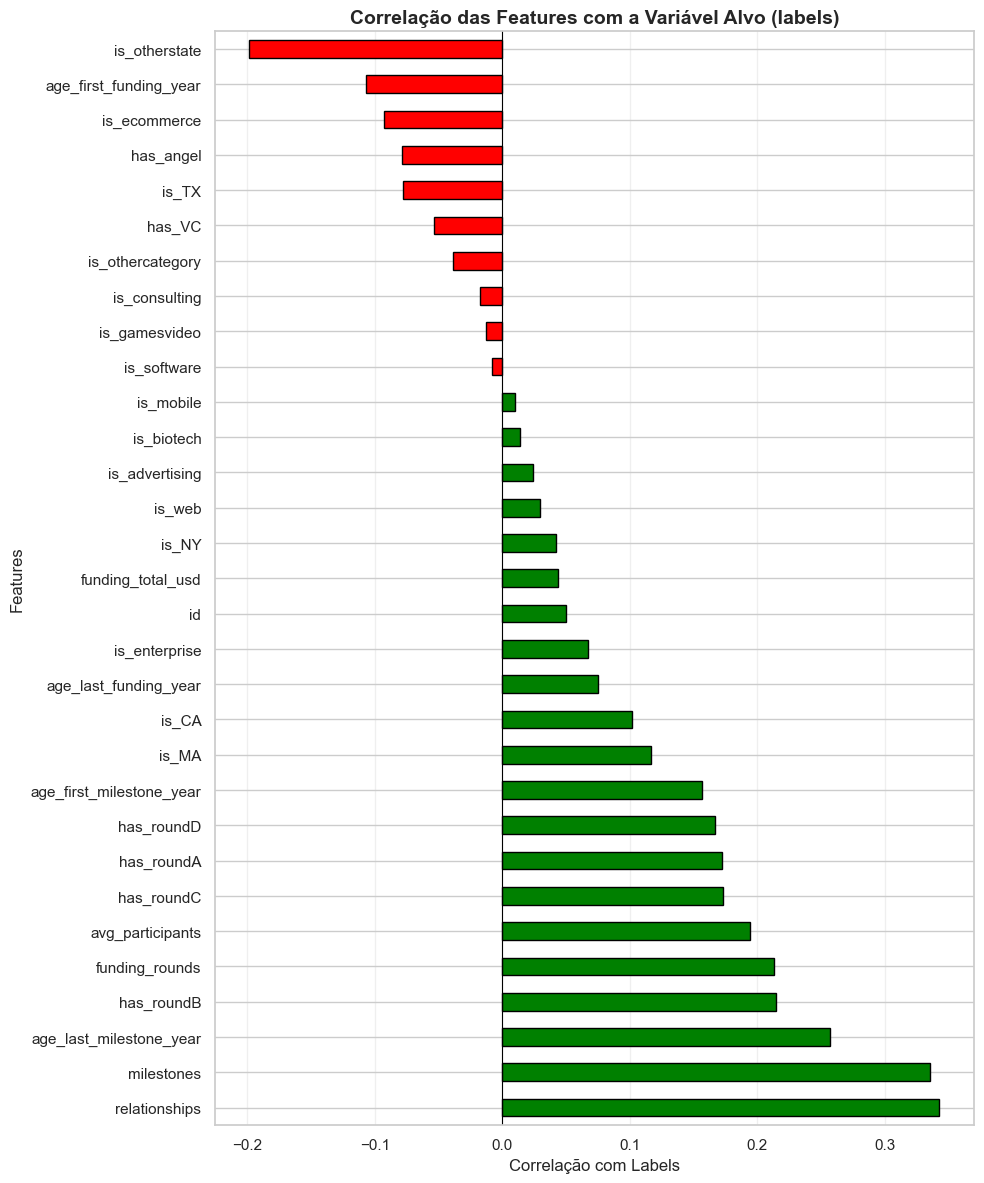

In [13]:
# Correlação com o alvo (usando correlação de Pearson)
target_corr = correlation_matrix[TARGET].drop(TARGET).sort_values(ascending=False)

print("=" * 60)
print("CORRELAÇÃO DAS FEATURES COM O TARGET (labels)")
print("=" * 60)
print("\nTop 15 Correlações Positivas:")
print(target_corr.head(15).to_string())
print("\nTop 15 Correlações Negativas:")
print(target_corr.tail(15).to_string())

# Visualização das correlações com o target
fig, ax = plt.subplots(figsize=(10, 12))
colors = ['green' if x > 0 else 'red' for x in target_corr.values]
target_corr.plot(kind='barh', ax=ax, color=colors, edgecolor='black')
ax.set_xlabel('Correlação com Labels', fontsize=12)
ax.set_ylabel('Features', fontsize=12)
ax.set_title('Correlação das Features com a Variável Alvo (labels)', fontsize=14, fontweight='bold')
ax.axvline(0, color='black', linewidth=0.8)
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


### 1.10 Análise Bivariada: Features vs Target


C:\Users\Inteli\AppData\Local\Temp\ipykernel_24168\1435379759.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[idx].boxplot(data_to_plot, labels=['Falha (0)', 'Sucesso (1)'],
C:\Users\Inteli\AppData\Local\Temp\ipykernel_24168\1435379759.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[idx].boxplot(data_to_plot, labels=['Falha (0)', 'Sucesso (1)'],
C:\Users\Inteli\AppData\Local\Temp\ipykernel_24168\1435379759.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[idx].boxplot(data_to_plot, labels=['Falha (0)', 'Sucesso (1)'],
C:\Users\Inteli\AppData\Local\Temp\ipykernel_24168\1435379

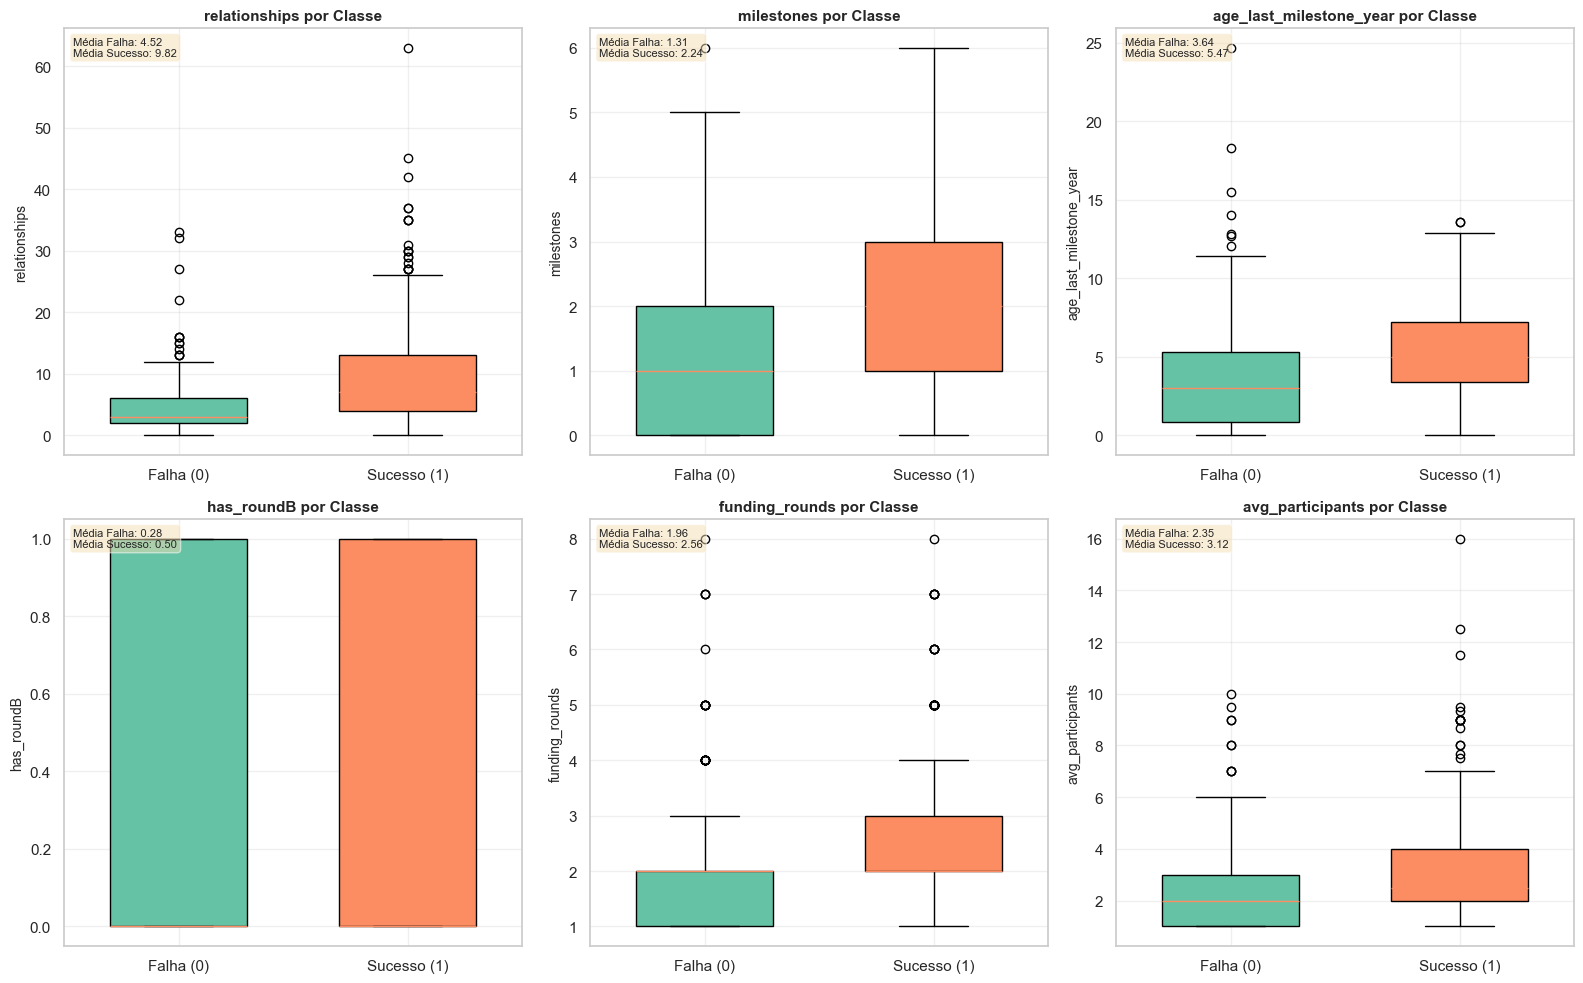

In [14]:
# Análise bivariada: distribuição das principais features por classe do target
top_corr_features = target_corr.head(6).index.tolist()

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

for idx, col in enumerate(top_corr_features):
    if col in X.columns:
        # Boxplot por classe
        data_to_plot = [df_train[df_train[TARGET] == 0][col].dropna(), 
                        df_train[df_train[TARGET] == 1][col].dropna()]
        bp = axes[idx].boxplot(data_to_plot, labels=['Falha (0)', 'Sucesso (1)'], 
                               patch_artist=True, widths=0.6)
        
        # Colorir boxplots
        for patch, color in zip(bp['boxes'], [CUSTOM_PALETTE[0], CUSTOM_PALETTE[1]]):
            patch.set_facecolor(color)
        
        axes[idx].set_title(f'{col} por Classe', fontsize=11, fontweight='bold')
        axes[idx].set_ylabel(col, fontsize=10)
        axes[idx].grid(alpha=0.3)
        
        # Adicionar médias
        mean_0 = df_train[df_train[TARGET] == 0][col].mean()
        mean_1 = df_train[df_train[TARGET] == 1][col].mean()
        axes[idx].text(0.02, 0.98, f'Média Falha: {mean_0:.2f}\nMédia Sucesso: {mean_1:.2f}', 
                      transform=axes[idx].transAxes, verticalalignment='top',
                      bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5), fontsize=8)

plt.tight_layout()
plt.show()


### 1.11 Análise de Features Categóricas


ANÁLISE DE category_code

Total de categorias: 34

Top 10 categorias:
category_code
software         105
web               97
mobile            65
enterprise        53
advertising       45
games_video       37
biotech           25
semiconductor     24
ecommerce         20
hardware          18


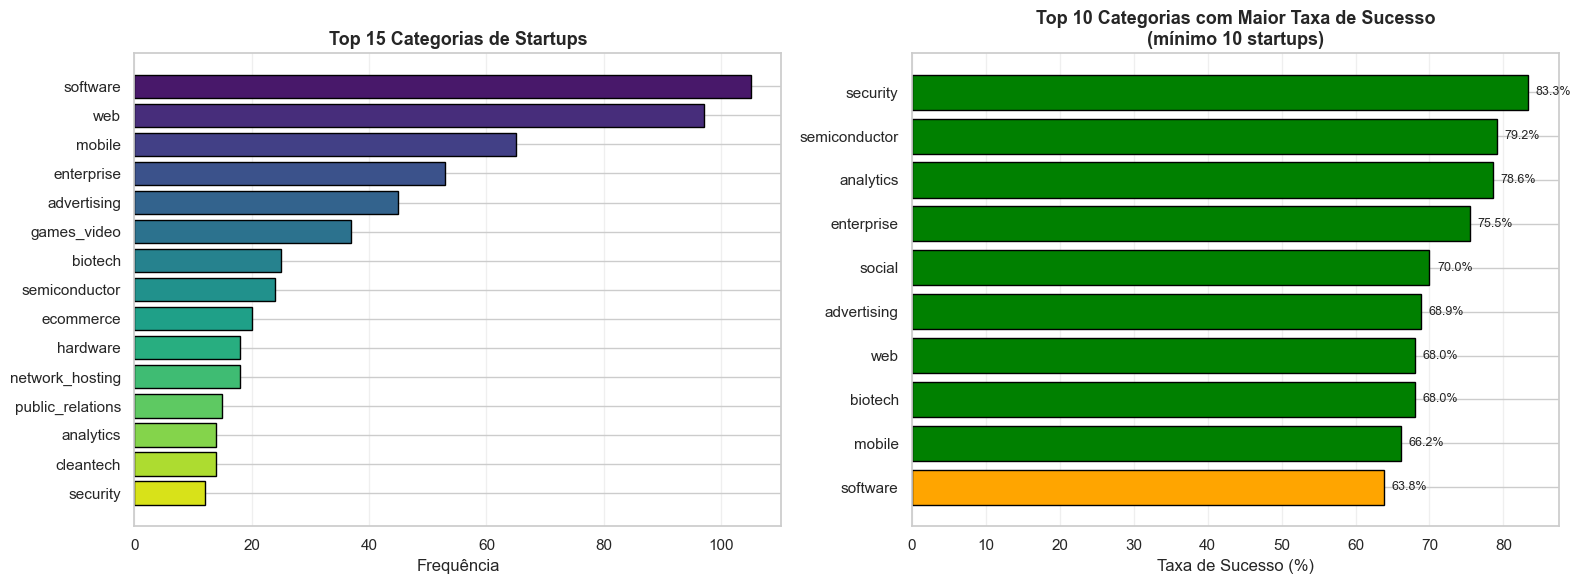



Taxa de Sucesso por Categoria (top 10, mín. 10 startups):
                   mean  count
category_code                 
security       0.833333     12
semiconductor  0.791667     24
analytics      0.785714     14
enterprise     0.754717     53
social         0.700000     10
advertising    0.688889     45
web            0.680412     97
biotech        0.680000     25
mobile         0.661538     65
software       0.638095    105


In [15]:
# Análise da feature categórica principal: category_code
if 'category_code' in X.columns:
    print("=" * 60)
    print("ANÁLISE DE category_code")
    print("=" * 60)
    category_counts = X['category_code'].value_counts()
    print(f"\nTotal de categorias: {len(category_counts)}")
    print(f"\nTop 10 categorias:\n{category_counts.head(10).to_string()}")
    
    # Visualizar top categorias
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Gráfico de barras das top 15 categorias
    top_15_cats = category_counts.head(15)
    colors_cat = sns.color_palette("viridis", n_colors=len(top_15_cats))
    axes[0].barh(range(len(top_15_cats)), top_15_cats.values, color=colors_cat, edgecolor='black')
    axes[0].set_yticks(range(len(top_15_cats)))
    axes[0].set_yticklabels(top_15_cats.index)
    axes[0].set_xlabel('Frequência', fontsize=12)
    axes[0].set_title('Top 15 Categorias de Startups', fontsize=13, fontweight='bold')
    axes[0].grid(axis='x', alpha=0.3)
    axes[0].invert_yaxis()
    
    # Taxa de sucesso por categoria (top 10)
    success_by_category = df_train.groupby('category_code')[TARGET].agg(['mean', 'count'])
    success_by_category = success_by_category[success_by_category['count'] >= 10].sort_values('mean', ascending=False).head(10)
    
    colors_success = ['green' if x > 0.65 else 'orange' if x > 0.6 else 'red' for x in success_by_category['mean']]
    axes[1].barh(range(len(success_by_category)), success_by_category['mean'].values * 100, 
                 color=colors_success, edgecolor='black')
    axes[1].set_yticks(range(len(success_by_category)))
    axes[1].set_yticklabels(success_by_category.index)
    axes[1].set_xlabel('Taxa de Sucesso (%)', fontsize=12)
    axes[1].set_title('Top 10 Categorias com Maior Taxa de Sucesso\n(mínimo 10 startups)', 
                      fontsize=13, fontweight='bold')
    axes[1].grid(axis='x', alpha=0.3)
    axes[1].invert_yaxis()
    
    # Adicionar valores nas barras
    for i, v in enumerate(success_by_category['mean'].values * 100):
        axes[1].text(v + 1, i, f'{v:.1f}%', va='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n\nTaxa de Sucesso por Categoria (top 10, mín. 10 startups):")
    print(success_by_category.to_string())


### 1.13 Análise de Features Binárias (Rodadas de Investimento)


ANÁLISE DAS RODADAS DE INVESTIMENTO

    Rodada  Total_Startups  Percentual  Taxa_Sucesso  Taxa_Falha
has_roundA             333   51.547988     72.672673   56.230032
has_roundB             271   41.950464     76.752768   56.000000
has_roundC             152   23.529412     79.605263   60.121457
has_roundD              59    9.133127     89.830508   62.180579


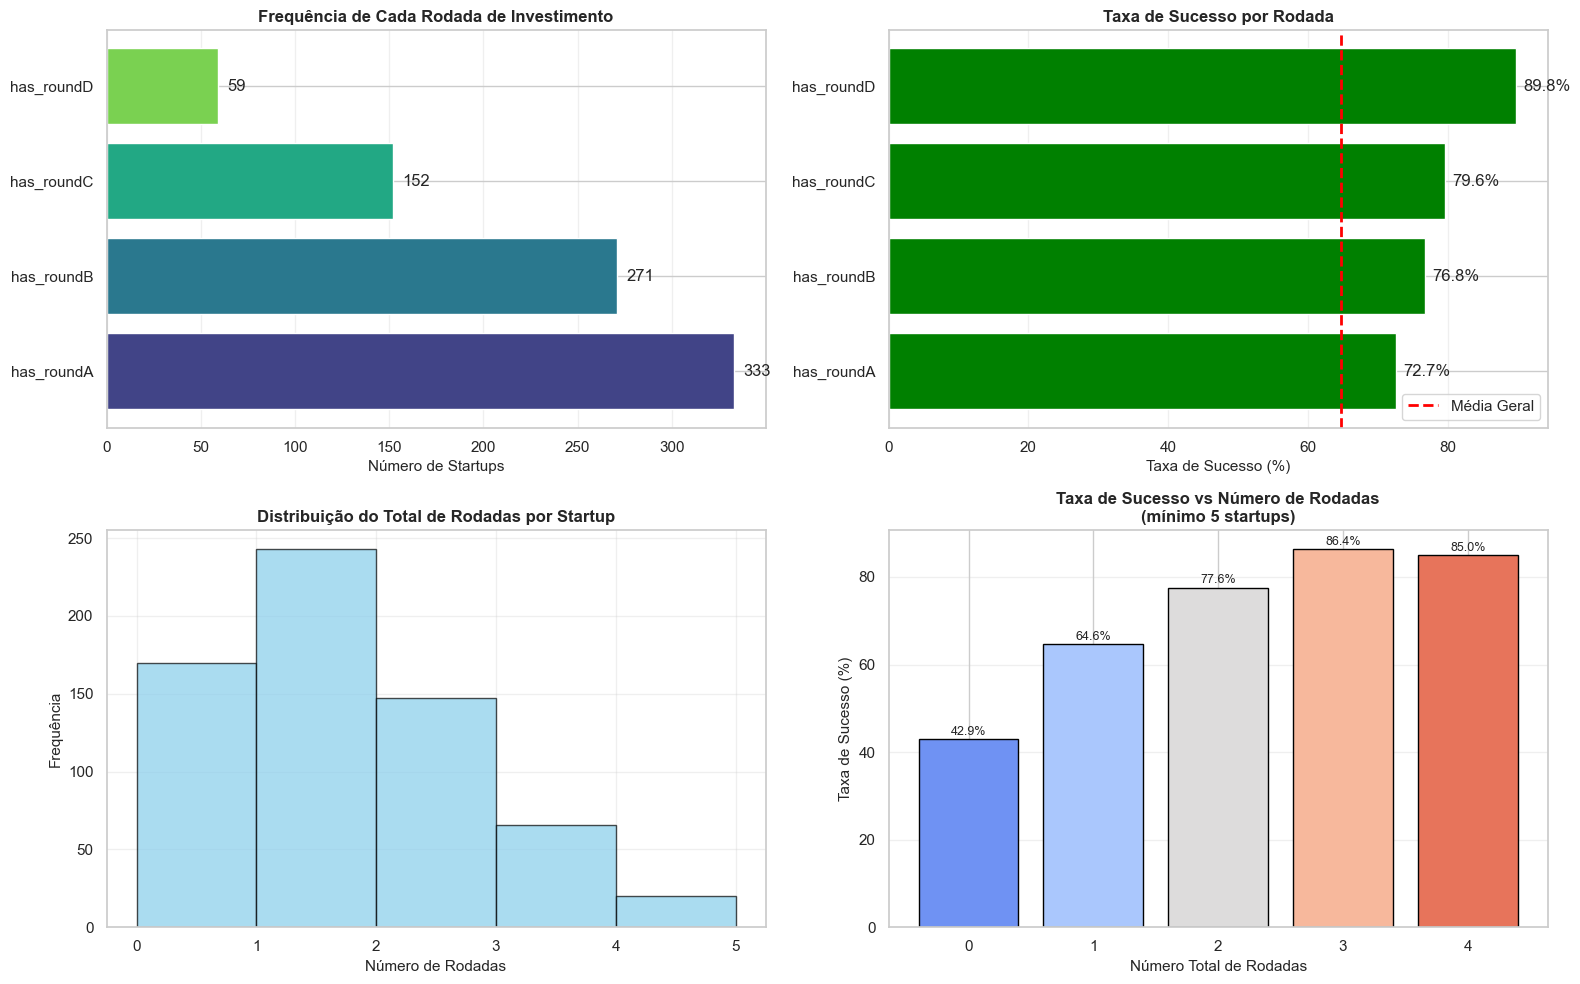

In [16]:
# Análise das features de rodadas de investimento
round_features = [col for col in df_train.columns if col.startswith('has_round')]

if len(round_features) > 0:
    print("=" * 60)
    print("ANÁLISE DAS RODADAS DE INVESTIMENTO")
    print("=" * 60)
    
    # Estatísticas de cada rodada
    round_stats = pd.DataFrame({
        'Rodada': round_features,
        'Total_Startups': [df_train[col].sum() for col in round_features],
        'Percentual': [df_train[col].mean() * 100 for col in round_features],
        'Taxa_Sucesso': [df_train[df_train[col] == 1][TARGET].mean() * 100 for col in round_features],
        'Taxa_Falha': [df_train[df_train[col] == 0][TARGET].mean() * 100 for col in round_features]
    })
    round_stats = round_stats.sort_values('Total_Startups', ascending=False)
    print("\n" + round_stats.to_string(index=False))
    
    # Visualização
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    # 1. Frequência de cada rodada
    axes[0, 0].barh(round_stats['Rodada'], round_stats['Total_Startups'], 
                     color=sns.color_palette("viridis", len(round_stats)))
    axes[0, 0].set_xlabel('Número de Startups', fontsize=11)
    axes[0, 0].set_title('Frequência de Cada Rodada de Investimento', fontsize=12, fontweight='bold')
    axes[0, 0].grid(axis='x', alpha=0.3)
    for i, v in enumerate(round_stats['Total_Startups']):
        axes[0, 0].text(v + 5, i, str(int(v)), va='center')
    
    # 2. Taxa de sucesso por rodada
    colors_success = ['green' if x > 60 else 'orange' if x > 50 else 'red' 
                      for x in round_stats['Taxa_Sucesso']]
    axes[0, 1].barh(round_stats['Rodada'], round_stats['Taxa_Sucesso'], color=colors_success)
    axes[0, 1].set_xlabel('Taxa de Sucesso (%)', fontsize=11)
    axes[0, 1].set_title('Taxa de Sucesso por Rodada', fontsize=12, fontweight='bold')
    axes[0, 1].grid(axis='x', alpha=0.3)
    axes[0, 1].axvline(df_train[TARGET].mean() * 100, color='red', linestyle='--', 
                       linewidth=2, label='Média Geral')
    axes[0, 1].legend()
    for i, v in enumerate(round_stats['Taxa_Sucesso']):
        axes[0, 1].text(v + 1, i, f'{v:.1f}%', va='center')
    
    # 3. Distribuição de número de rodadas por startup
    total_rounds_per_startup = df_train[round_features].sum(axis=1)
    axes[1, 0].hist(total_rounds_per_startup, bins=range(0, total_rounds_per_startup.max()+2), 
                    color='skyblue', edgecolor='black', alpha=0.7)
    axes[1, 0].set_xlabel('Número de Rodadas', fontsize=11)
    axes[1, 0].set_ylabel('Frequência', fontsize=11)
    axes[1, 0].set_title('Distribuição do Total de Rodadas por Startup', fontsize=12, fontweight='bold')
    axes[1, 0].grid(alpha=0.3)
    
    # 4. Taxa de sucesso por número total de rodadas
    success_by_rounds = df_train.groupby(total_rounds_per_startup)[TARGET].agg(['mean', 'count'])
    success_by_rounds = success_by_rounds[success_by_rounds['count'] >= 5]  # Mínimo 5 startups
    axes[1, 1].bar(success_by_rounds.index, success_by_rounds['mean'] * 100, 
                   color=sns.color_palette("coolwarm", len(success_by_rounds)), edgecolor='black')
    axes[1, 1].set_xlabel('Número Total de Rodadas', fontsize=11)
    axes[1, 1].set_ylabel('Taxa de Sucesso (%)', fontsize=11)
    axes[1, 1].set_title('Taxa de Sucesso vs Número de Rodadas\n(mínimo 5 startups)', 
                         fontsize=12, fontweight='bold')
    axes[1, 1].grid(axis='y', alpha=0.3)
    for i, (idx, val) in enumerate(zip(success_by_rounds.index, success_by_rounds['mean'] * 100)):
        axes[1, 1].text(idx, val + 1, f'{val:.1f}%', ha='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()


### 1.14 Análise Geográfica (Localização das Startups)


ANÁLISE GEOGRÁFICA - DISTRIBUIÇÃO DAS STARTUPS

       Estado  Total_Startups  Percentual  Taxa_Sucesso  Funding_Medio  Relationships_Medio
        is_CA             353   54.643963     69.121813   2.104332e+07             8.512748
is_otherstate             136   21.052632     46.323529   6.243913e+07             5.970588
        is_NY              71   10.990712     70.422535   1.422800e+07             8.802817
        is_MA              61    9.442724     81.967213   2.434378e+07             8.163934
        is_TX              24    3.715170     45.833333   2.526896e+07             7.583333


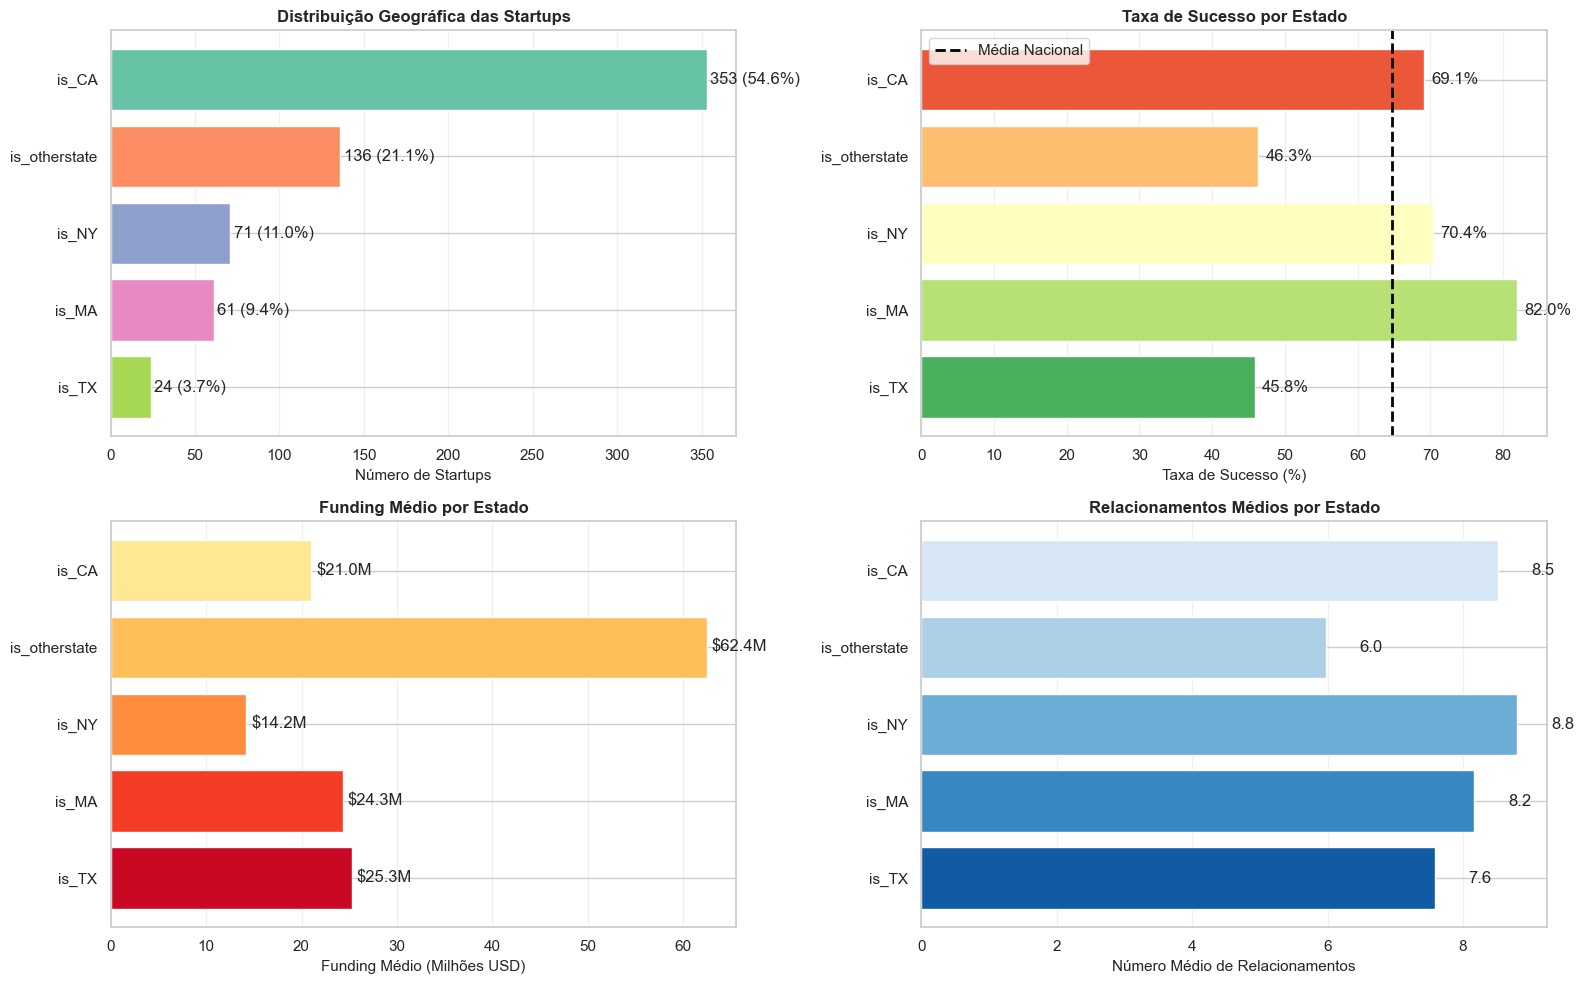

In [17]:
# Análise geográfica
location_features = [col for col in df_train.columns if col.startswith('is_') and 
                     col not in ['is_software', 'is_web', 'is_mobile', 'is_enterprise', 
                                 'is_advertising', 'is_gamesvideo', 'is_ecommerce', 
                                 'is_biotech', 'is_consulting', 'is_othercategory']]

if len(location_features) > 0:
    print("=" * 80)
    print("ANÁLISE GEOGRÁFICA - DISTRIBUIÇÃO DAS STARTUPS")
    print("=" * 80)
    
    # Estatísticas por localização
    location_stats = pd.DataFrame({
        'Estado': location_features,
        'Total_Startups': [df_train[col].sum() for col in location_features],
        'Percentual': [df_train[col].mean() * 100 for col in location_features],
        'Taxa_Sucesso': [df_train[df_train[col] == 1][TARGET].mean() * 100 for col in location_features],
        'Funding_Medio': [df_train[df_train[col] == 1]['funding_total_usd'].mean() for col in location_features],
        'Relationships_Medio': [df_train[df_train[col] == 1]['relationships'].mean() for col in location_features]
    })
    location_stats = location_stats.sort_values('Total_Startups', ascending=False)
    print("\n" + location_stats.to_string(index=False))
    
    # Visualização
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    # 1. Distribuição geográfica
    axes[0, 0].barh(location_stats['Estado'], location_stats['Total_Startups'], 
                    color=sns.color_palette("Set2", len(location_stats)))
    axes[0, 0].set_xlabel('Número de Startups', fontsize=11)
    axes[0, 0].set_title('Distribuição Geográfica das Startups', fontsize=12, fontweight='bold')
    axes[0, 0].grid(axis='x', alpha=0.3)
    axes[0, 0].invert_yaxis()
    for i, v in enumerate(location_stats['Total_Startups']):
        axes[0, 0].text(v + 2, i, f'{int(v)} ({location_stats.iloc[i]["Percentual"]:.1f}%)', va='center')
    
    # 2. Taxa de sucesso por estado
    axes[0, 1].barh(location_stats['Estado'], location_stats['Taxa_Sucesso'], 
                    color=sns.color_palette("RdYlGn", len(location_stats)))
    axes[0, 1].set_xlabel('Taxa de Sucesso (%)', fontsize=11)
    axes[0, 1].set_title('Taxa de Sucesso por Estado', fontsize=12, fontweight='bold')
    axes[0, 1].axvline(df_train[TARGET].mean() * 100, color='black', linestyle='--', 
                       linewidth=2, label='Média Nacional')
    axes[0, 1].legend()
    axes[0, 1].grid(axis='x', alpha=0.3)
    axes[0, 1].invert_yaxis()
    for i, v in enumerate(location_stats['Taxa_Sucesso']):
        axes[0, 1].text(v + 1, i, f'{v:.1f}%', va='center')
    
    # 3. Funding médio por estado
    axes[1, 0].barh(location_stats['Estado'], location_stats['Funding_Medio'] / 1e6, 
                    color=sns.color_palette("YlOrRd", len(location_stats)))
    axes[1, 0].set_xlabel('Funding Médio (Milhões USD)', fontsize=11)
    axes[1, 0].set_title('Funding Médio por Estado', fontsize=12, fontweight='bold')
    axes[1, 0].grid(axis='x', alpha=0.3)
    axes[1, 0].invert_yaxis()
    for i, v in enumerate(location_stats['Funding_Medio'] / 1e6):
        axes[1, 0].text(v + 0.5, i, f'${v:.1f}M', va='center')
    
    # 4. Relationships médio por estado
    axes[1, 1].barh(location_stats['Estado'], location_stats['Relationships_Medio'], 
                    color=sns.color_palette("Blues", len(location_stats)))
    axes[1, 1].set_xlabel('Número Médio de Relacionamentos', fontsize=11)
    axes[1, 1].set_title('Relacionamentos Médios por Estado', fontsize=12, fontweight='bold')
    axes[1, 1].grid(axis='x', alpha=0.3)
    axes[1, 1].invert_yaxis()
    for i, v in enumerate(location_stats['Relationships_Medio']):
        axes[1, 1].text(v + 0.5, i, f'{v:.1f}', va='center')
    
    plt.tight_layout()
    plt.show()


### 1.15 Análise de Setor/Categoria


ANÁLISE POR SETOR DE ATUAÇÃO

        Setor  Total_Startups  Percentual  Taxa_Sucesso  Funding_Medio_M  Milestones_Medio
OTHERCATEGORY             197   30.495356     61.928934        24.056463          1.639594
     SOFTWARE             105   16.253870     63.809524        17.710487          1.419048
          WEB              97   15.015480     68.041237        14.666505          2.628866
       MOBILE              65   10.061920     66.153846       110.150689          2.353846
   ENTERPRISE              53    8.204334     75.471698        18.182487          2.207547
  ADVERTISING              45    6.965944     68.888889        13.777387          2.155556
   GAMESVIDEO              37    5.727554     62.162162        15.589285          2.216216
      BIOTECH              25    3.869969     68.000000        55.145774          0.640000
    ECOMMERCE              20    3.095975     40.000000        14.090346          1.950000
   CONSULTING               2    0.309598     50.000000     

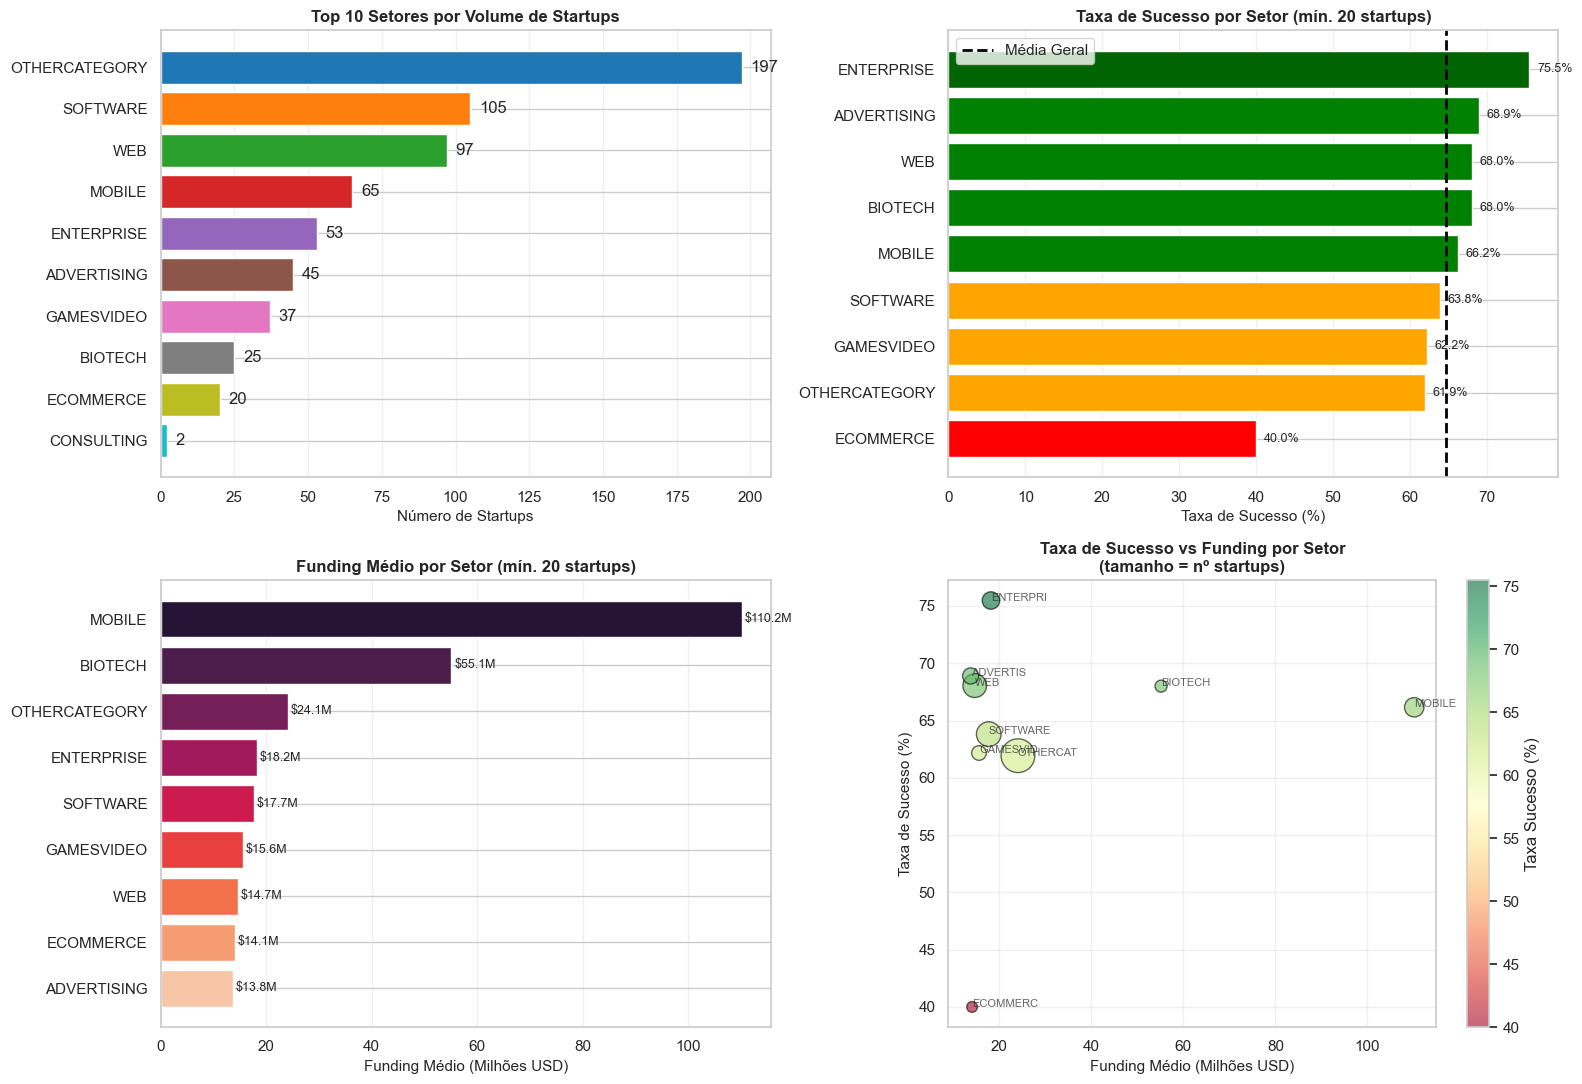

In [18]:
# Análise de setores (features binárias is_*)
sector_features = [col for col in df_train.columns if col.startswith('is_') and 
                   col in ['is_software', 'is_web', 'is_mobile', 'is_enterprise', 
                           'is_advertising', 'is_gamesvideo', 'is_ecommerce', 
                           'is_biotech', 'is_consulting', 'is_othercategory']]

if len(sector_features) > 0:
    print("=" * 80)
    print("ANÁLISE POR SETOR DE ATUAÇÃO")
    print("=" * 80)
    
    # Estatísticas por setor
    sector_stats = pd.DataFrame({
        'Setor': [col.replace('is_', '').upper() for col in sector_features],
        'Feature': sector_features,
        'Total_Startups': [df_train[col].sum() for col in sector_features],
        'Percentual': [df_train[col].mean() * 100 for col in sector_features],
        'Taxa_Sucesso': [df_train[df_train[col] == 1][TARGET].mean() * 100 for col in sector_features],
        'Funding_Medio_M': [df_train[df_train[col] == 1]['funding_total_usd'].mean() / 1e6 for col in sector_features],
        'Milestones_Medio': [df_train[df_train[col] == 1]['milestones'].mean() for col in sector_features]
    })
    sector_stats = sector_stats.sort_values('Total_Startups', ascending=False)
    print("\n" + sector_stats[['Setor', 'Total_Startups', 'Percentual', 'Taxa_Sucesso', 
                                'Funding_Medio_M', 'Milestones_Medio']].to_string(index=False))
    
    # Visualização
    fig, axes = plt.subplots(2, 2, figsize=(16, 11))
    
    # 1. Top setores por volume
    top_sectors = sector_stats.nlargest(10, 'Total_Startups')
    axes[0, 0].barh(top_sectors['Setor'], top_sectors['Total_Startups'], 
                    color=sns.color_palette("tab10", len(top_sectors)))
    axes[0, 0].set_xlabel('Número de Startups', fontsize=11)
    axes[0, 0].set_title('Top 10 Setores por Volume de Startups', fontsize=12, fontweight='bold')
    axes[0, 0].grid(axis='x', alpha=0.3)
    axes[0, 0].invert_yaxis()
    for i, v in enumerate(top_sectors['Total_Startups']):
        axes[0, 0].text(v + 3, i, f'{int(v)}', va='center')
    
    # 2. Taxa de sucesso por setor (apenas setores com 20+ startups)
    significant_sectors = sector_stats[sector_stats['Total_Startups'] >= 20].sort_values('Taxa_Sucesso', ascending=False)
    colors_sector = ['darkgreen' if x > 70 else 'green' if x > 65 else 'orange' if x > 60 else 'red' 
                     for x in significant_sectors['Taxa_Sucesso']]
    axes[0, 1].barh(significant_sectors['Setor'], significant_sectors['Taxa_Sucesso'], color=colors_sector)
    axes[0, 1].set_xlabel('Taxa de Sucesso (%)', fontsize=11)
    axes[0, 1].set_title('Taxa de Sucesso por Setor (mín. 20 startups)', fontsize=12, fontweight='bold')
    axes[0, 1].axvline(df_train[TARGET].mean() * 100, color='black', linestyle='--', 
                       linewidth=2, label='Média Geral')
    axes[0, 1].legend()
    axes[0, 1].grid(axis='x', alpha=0.3)
    axes[0, 1].invert_yaxis()
    for i, v in enumerate(significant_sectors['Taxa_Sucesso']):
        axes[0, 1].text(v + 1, i, f'{v:.1f}%', va='center', fontsize=9)
    
    # 3. Funding médio por setor
    top_funding = sector_stats[sector_stats['Total_Startups'] >= 20].sort_values('Funding_Medio_M', ascending=False)
    axes[1, 0].barh(top_funding['Setor'], top_funding['Funding_Medio_M'], 
                    color=sns.color_palette("rocket", len(top_funding)))
    axes[1, 0].set_xlabel('Funding Médio (Milhões USD)', fontsize=11)
    axes[1, 0].set_title('Funding Médio por Setor (mín. 20 startups)', fontsize=12, fontweight='bold')
    axes[1, 0].grid(axis='x', alpha=0.3)
    axes[1, 0].invert_yaxis()
    for i, v in enumerate(top_funding['Funding_Medio_M']):
        axes[1, 0].text(v + 0.5, i, f'${v:.1f}M', va='center', fontsize=9)
    
    # 4. Scatter: Taxa de sucesso vs Funding médio
    scatter_data = sector_stats[sector_stats['Total_Startups'] >= 15]
    scatter = axes[1, 1].scatter(scatter_data['Funding_Medio_M'], scatter_data['Taxa_Sucesso'], 
                                 s=scatter_data['Total_Startups']*3, alpha=0.6, 
                                 c=scatter_data['Taxa_Sucesso'], cmap='RdYlGn', edgecolors='black')
    axes[1, 1].set_xlabel('Funding Médio (Milhões USD)', fontsize=11)
    axes[1, 1].set_ylabel('Taxa de Sucesso (%)', fontsize=11)
    axes[1, 1].set_title('Taxa de Sucesso vs Funding por Setor\n(tamanho = nº startups)', 
                         fontsize=12, fontweight='bold')
    axes[1, 1].grid(alpha=0.3)
    
    # Adicionar labels aos pontos
    for idx, row in scatter_data.iterrows():
        axes[1, 1].annotate(row['Setor'][:8], (row['Funding_Medio_M'], row['Taxa_Sucesso']), 
                           fontsize=8, alpha=0.7)
    
    plt.colorbar(scatter, ax=axes[1, 1], label='Taxa Sucesso (%)')
    plt.tight_layout()
    plt.show()


### 1.16 Análise Profunda de Funding


ANÁLISE DETALHADA DE FUNDING

Estatísticas por Categoria de Funding:
                 labels       funding_total_usd             funding_rounds  \
                  count  mean              mean      median           mean   
funding_category                                                             
<1M                  91  0.30         397421.48    300000.0           1.46   
1-5M                140  0.59        2975155.53   3000000.0           1.81   
5-10M                91  0.73        8022601.51   8000000.0           1.91   
10-50M              260  0.73       23622801.28  21625000.0           2.73   
>50M                 63  0.81       95713601.37  72300000.0           3.89   

                 relationships milestones  
                          mean       mean  
funding_category                           
<1M                       3.92       1.48  
1-5M                      6.15       2.11  
5-10M                     8.52       2.03  
10-50M                    9.08       1.89 

C:\Users\Inteli\AppData\Local\Temp\ipykernel_24168\656776948.py:40: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[0, 1].boxplot(data_success, labels=['Falha (0)', 'Sucesso (1)'],


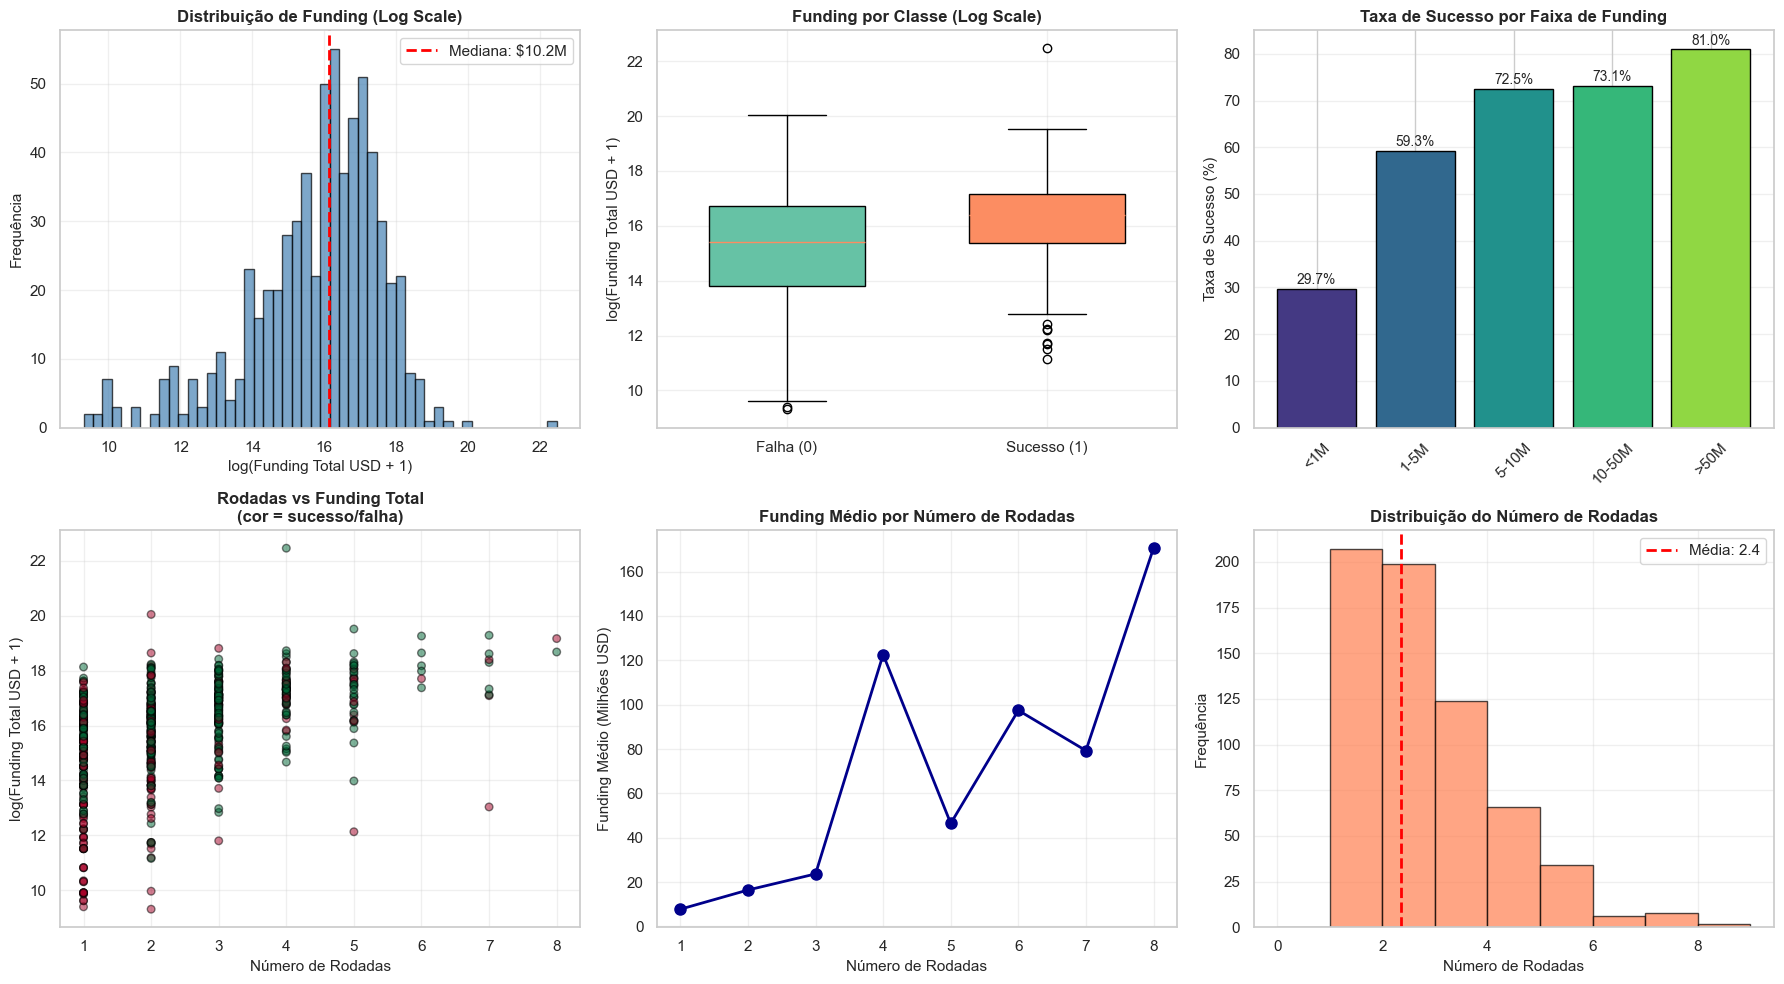

In [19]:
# Análise detalhada de funding
print("=" * 80)
print("ANÁLISE DETALHADA DE FUNDING")
print("=" * 80)

# Criar categorias de funding
df_train['funding_category'] = pd.cut(df_train['funding_total_usd'], 
                                       bins=[0, 1e6, 5e6, 10e6, 50e6, 1e9],
                                       labels=['<1M', '1-5M', '5-10M', '10-50M', '>50M'])

# Estatísticas por categoria de funding
funding_stats = df_train.groupby('funding_category', observed=True).agg({
    TARGET: ['count', 'mean'],
    'funding_total_usd': ['mean', 'median'],
    'funding_rounds': 'mean',
    'relationships': 'mean',
    'milestones': 'mean'
}).round(2)

print("\nEstatísticas por Categoria de Funding:")
print(funding_stats)

# Visualizações
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Distribuição de funding (log scale)
axes[0, 0].hist(np.log1p(df_train['funding_total_usd']), bins=50, color='steelblue', 
                edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('log(Funding Total USD + 1)', fontsize=11)
axes[0, 0].set_ylabel('Frequência', fontsize=11)
axes[0, 0].set_title('Distribuição de Funding (Log Scale)', fontsize=12, fontweight='bold')
axes[0, 0].grid(alpha=0.3)
axes[0, 0].axvline(np.log1p(df_train['funding_total_usd'].median()), color='red', 
                   linestyle='--', linewidth=2, label=f'Mediana: ${df_train["funding_total_usd"].median()/1e6:.1f}M')
axes[0, 0].legend()

# 2. Funding por sucesso/falha
data_success = [np.log1p(df_train[df_train[TARGET] == 0]['funding_total_usd']),
                np.log1p(df_train[df_train[TARGET] == 1]['funding_total_usd'])]
bp = axes[0, 1].boxplot(data_success, labels=['Falha (0)', 'Sucesso (1)'], 
                        patch_artist=True, widths=0.6)
for patch, color in zip(bp['boxes'], [CUSTOM_PALETTE[0], CUSTOM_PALETTE[1]]):
    patch.set_facecolor(color)
axes[0, 1].set_ylabel('log(Funding Total USD + 1)', fontsize=11)
axes[0, 1].set_title('Funding por Classe (Log Scale)', fontsize=12, fontweight='bold')
axes[0, 1].grid(alpha=0.3)

# 3. Taxa de sucesso por categoria de funding
funding_success = df_train.groupby('funding_category', observed=True)[TARGET].mean() * 100
axes[0, 2].bar(range(len(funding_success)), funding_success.values, 
               color=sns.color_palette("viridis", len(funding_success)), edgecolor='black')
axes[0, 2].set_xticks(range(len(funding_success)))
axes[0, 2].set_xticklabels(funding_success.index, rotation=45)
axes[0, 2].set_ylabel('Taxa de Sucesso (%)', fontsize=11)
axes[0, 2].set_title('Taxa de Sucesso por Faixa de Funding', fontsize=12, fontweight='bold')
axes[0, 2].grid(axis='y', alpha=0.3)
for i, v in enumerate(funding_success.values):
    axes[0, 2].text(i, v + 1, f'{v:.1f}%', ha='center', fontsize=10)

# 4. Funding rounds vs funding total
axes[1, 0].scatter(df_train['funding_rounds'], np.log1p(df_train['funding_total_usd']), 
                   c=df_train[TARGET], cmap='RdYlGn', alpha=0.5, edgecolors='black', s=30)
axes[1, 0].set_xlabel('Número de Rodadas', fontsize=11)
axes[1, 0].set_ylabel('log(Funding Total USD + 1)', fontsize=11)
axes[1, 0].set_title('Rodadas vs Funding Total\n(cor = sucesso/falha)', fontsize=12, fontweight='bold')
axes[1, 0].grid(alpha=0.3)

# 5. Média de funding por número de rodadas
funding_by_rounds = df_train.groupby('funding_rounds')['funding_total_usd'].mean() / 1e6
axes[1, 1].plot(funding_by_rounds.index, funding_by_rounds.values, marker='o', 
                linewidth=2, markersize=8, color='darkblue')
axes[1, 1].set_xlabel('Número de Rodadas', fontsize=11)
axes[1, 1].set_ylabel('Funding Médio (Milhões USD)', fontsize=11)
axes[1, 1].set_title('Funding Médio por Número de Rodadas', fontsize=12, fontweight='bold')
axes[1, 1].grid(alpha=0.3)

# 6. Distribuição de funding_rounds
axes[1, 2].hist(df_train['funding_rounds'], bins=range(0, int(df_train['funding_rounds'].max())+2), 
                color='coral', edgecolor='black', alpha=0.7)
axes[1, 2].set_xlabel('Número de Rodadas', fontsize=11)
axes[1, 2].set_ylabel('Frequência', fontsize=11)
axes[1, 2].set_title('Distribuição do Número de Rodadas', fontsize=12, fontweight='bold')
axes[1, 2].grid(alpha=0.3)
axes[1, 2].axvline(df_train['funding_rounds'].mean(), color='red', linestyle='--', 
                   linewidth=2, label=f'Média: {df_train["funding_rounds"].mean():.1f}')
axes[1, 2].legend()

plt.tight_layout()
plt.show()

# Remover coluna temporária
df_train = df_train.drop('funding_category', axis=1)


### 1.17 Análise de Relacionamentos e Networking


ANÁLISE DE NETWORKING E MILESTONES


C:\Users\Inteli\AppData\Local\Temp\ipykernel_24168\2372389016.py:24: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[0, 1].boxplot(data_rel, labels=['Falha (0)', 'Sucesso (1)'],


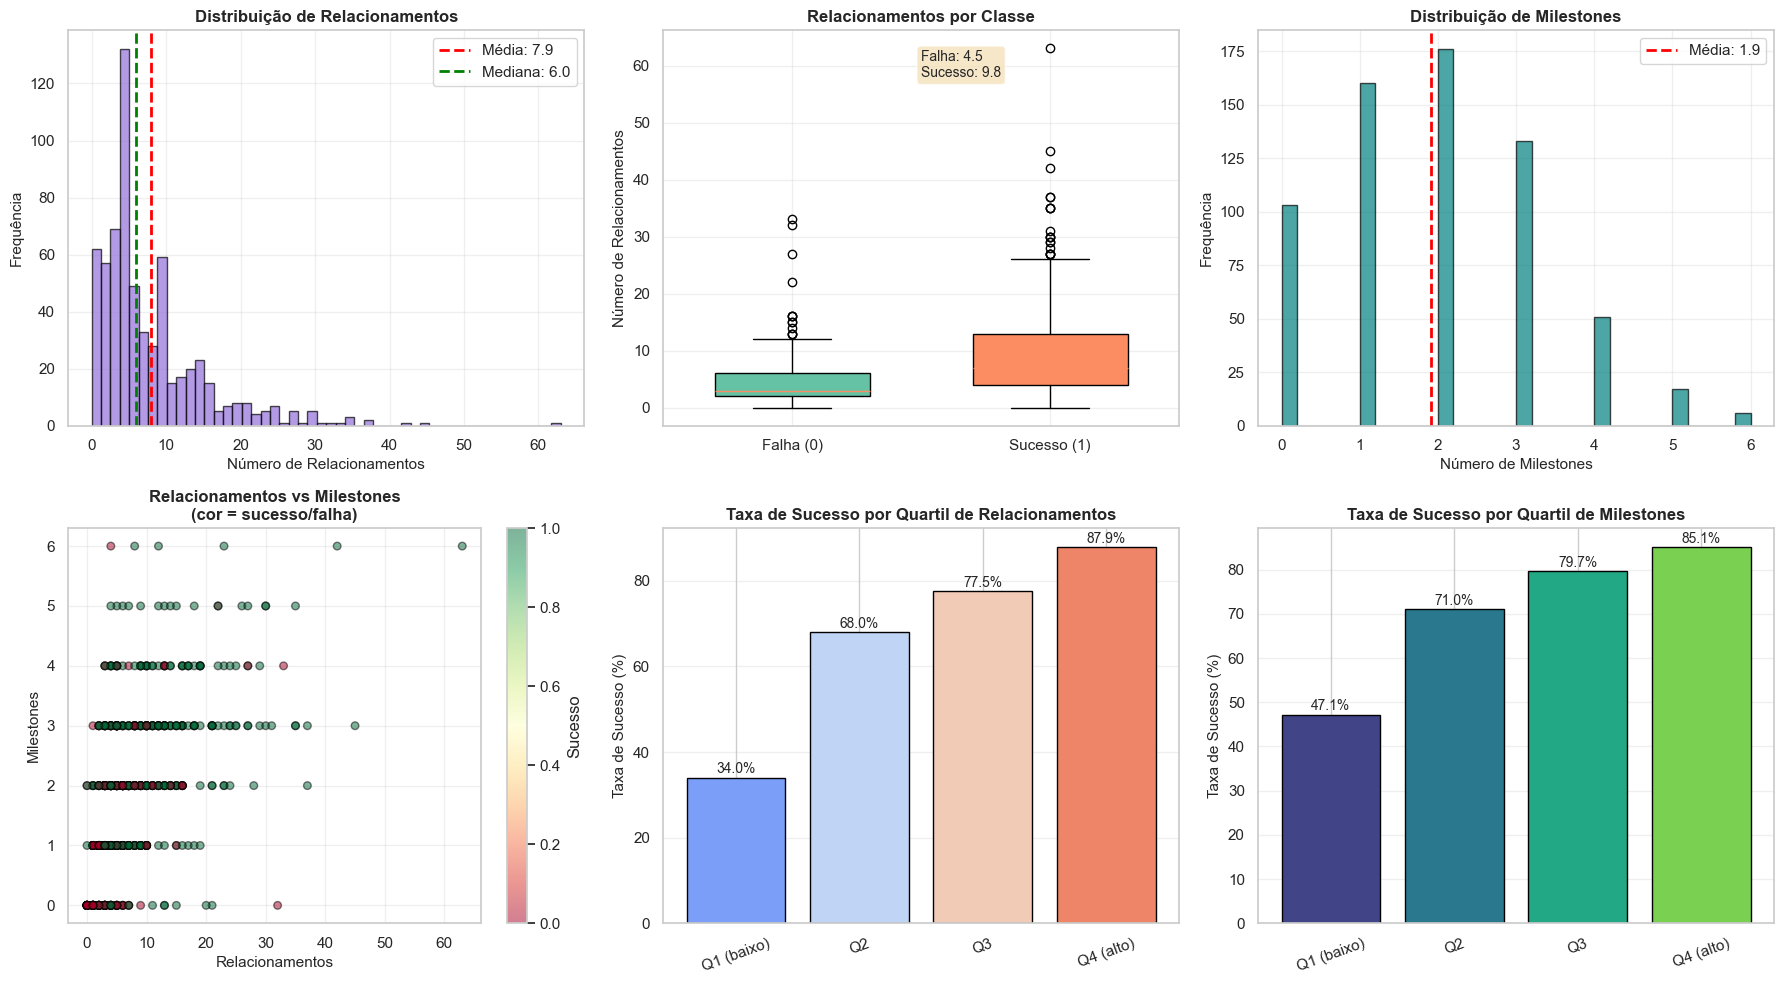

In [20]:
# Análise de Relationships e Milestones
print("=" * 80)
print("ANÁLISE DE NETWORKING E MILESTONES")
print("=" * 80)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Distribuição de relationships
axes[0, 0].hist(df_train['relationships'], bins=50, color='mediumpurple', 
                edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Número de Relacionamentos', fontsize=11)
axes[0, 0].set_ylabel('Frequência', fontsize=11)
axes[0, 0].set_title('Distribuição de Relacionamentos', fontsize=12, fontweight='bold')
axes[0, 0].grid(alpha=0.3)
axes[0, 0].axvline(df_train['relationships'].mean(), color='red', linestyle='--', 
                   linewidth=2, label=f'Média: {df_train["relationships"].mean():.1f}')
axes[0, 0].axvline(df_train['relationships'].median(), color='green', linestyle='--', 
                   linewidth=2, label=f'Mediana: {df_train["relationships"].median():.1f}')
axes[0, 0].legend()

# 2. Relationships por sucesso/falha
data_rel = [df_train[df_train[TARGET] == 0]['relationships'],
            df_train[df_train[TARGET] == 1]['relationships']]
bp = axes[0, 1].boxplot(data_rel, labels=['Falha (0)', 'Sucesso (1)'], 
                        patch_artist=True, widths=0.6)
for patch, color in zip(bp['boxes'], [CUSTOM_PALETTE[0], CUSTOM_PALETTE[1]]):
    patch.set_facecolor(color)
axes[0, 1].set_ylabel('Número de Relacionamentos', fontsize=11)
axes[0, 1].set_title('Relacionamentos por Classe', fontsize=12, fontweight='bold')
axes[0, 1].grid(alpha=0.3)
mean_0 = df_train[df_train[TARGET] == 0]['relationships'].mean()
mean_1 = df_train[df_train[TARGET] == 1]['relationships'].mean()
axes[0, 1].text(0.5, 0.95, f'Falha: {mean_0:.1f}\nSucesso: {mean_1:.1f}', 
                transform=axes[0, 1].transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7), fontsize=10)

# 3. Distribuição de milestones
axes[0, 2].hist(df_train['milestones'], bins=30, color='teal', 
                edgecolor='black', alpha=0.7)
axes[0, 2].set_xlabel('Número de Milestones', fontsize=11)
axes[0, 2].set_ylabel('Frequência', fontsize=11)
axes[0, 2].set_title('Distribuição de Milestones', fontsize=12, fontweight='bold')
axes[0, 2].grid(alpha=0.3)
axes[0, 2].axvline(df_train['milestones'].mean(), color='red', linestyle='--', 
                   linewidth=2, label=f'Média: {df_train["milestones"].mean():.1f}')
axes[0, 2].legend()

# 4. Relationships vs Milestones (scatter)
scatter = axes[1, 0].scatter(df_train['relationships'], df_train['milestones'], 
                             c=df_train[TARGET], cmap='RdYlGn', alpha=0.5, 
                             edgecolors='black', s=30)
axes[1, 0].set_xlabel('Relacionamentos', fontsize=11)
axes[1, 0].set_ylabel('Milestones', fontsize=11)
axes[1, 0].set_title('Relacionamentos vs Milestones\n(cor = sucesso/falha)', 
                     fontsize=12, fontweight='bold')
axes[1, 0].grid(alpha=0.3)
plt.colorbar(scatter, ax=axes[1, 0], label='Sucesso')

# 5. Taxa de sucesso por quartil de relationships
df_train['rel_quartile'] = pd.qcut(df_train['relationships'], q=4, 
                                    labels=['Q1 (baixo)', 'Q2', 'Q3', 'Q4 (alto)'], 
                                    duplicates='drop')
rel_success = df_train.groupby('rel_quartile', observed=True)[TARGET].mean() * 100
axes[1, 1].bar(range(len(rel_success)), rel_success.values, 
               color=sns.color_palette("coolwarm", len(rel_success)), edgecolor='black')
axes[1, 1].set_xticks(range(len(rel_success)))
axes[1, 1].set_xticklabels(rel_success.index, rotation=20)
axes[1, 1].set_ylabel('Taxa de Sucesso (%)', fontsize=11)
axes[1, 1].set_title('Taxa de Sucesso por Quartil de Relacionamentos', 
                     fontsize=12, fontweight='bold')
axes[1, 1].grid(axis='y', alpha=0.3)
for i, v in enumerate(rel_success.values):
    axes[1, 1].text(i, v + 1, f'{v:.1f}%', ha='center', fontsize=10)

# 6. Taxa de sucesso por quartil de milestones
df_train['mil_quartile'] = pd.qcut(df_train['milestones'], q=4, 
                                    labels=['Q1 (baixo)', 'Q2', 'Q3', 'Q4 (alto)'], 
                                    duplicates='drop')
mil_success = df_train.groupby('mil_quartile', observed=True)[TARGET].mean() * 100
axes[1, 2].bar(range(len(mil_success)), mil_success.values, 
               color=sns.color_palette("viridis", len(mil_success)), edgecolor='black')
axes[1, 2].set_xticks(range(len(mil_success)))
axes[1, 2].set_xticklabels(mil_success.index, rotation=20)
axes[1, 2].set_ylabel('Taxa de Sucesso (%)', fontsize=11)
axes[1, 2].set_title('Taxa de Sucesso por Quartil de Milestones', 
                     fontsize=12, fontweight='bold')
axes[1, 2].grid(axis='y', alpha=0.3)
for i, v in enumerate(mil_success.values):
    axes[1, 2].text(i, v + 1, f'{v:.1f}%', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

# Remover colunas temporárias
df_train = df_train.drop(['rel_quartile', 'mil_quartile'], axis=1)


### 1.18 Pairplot das Features Mais Importantes


PAIRPLOT DAS FEATURES MAIS IMPORTANTES


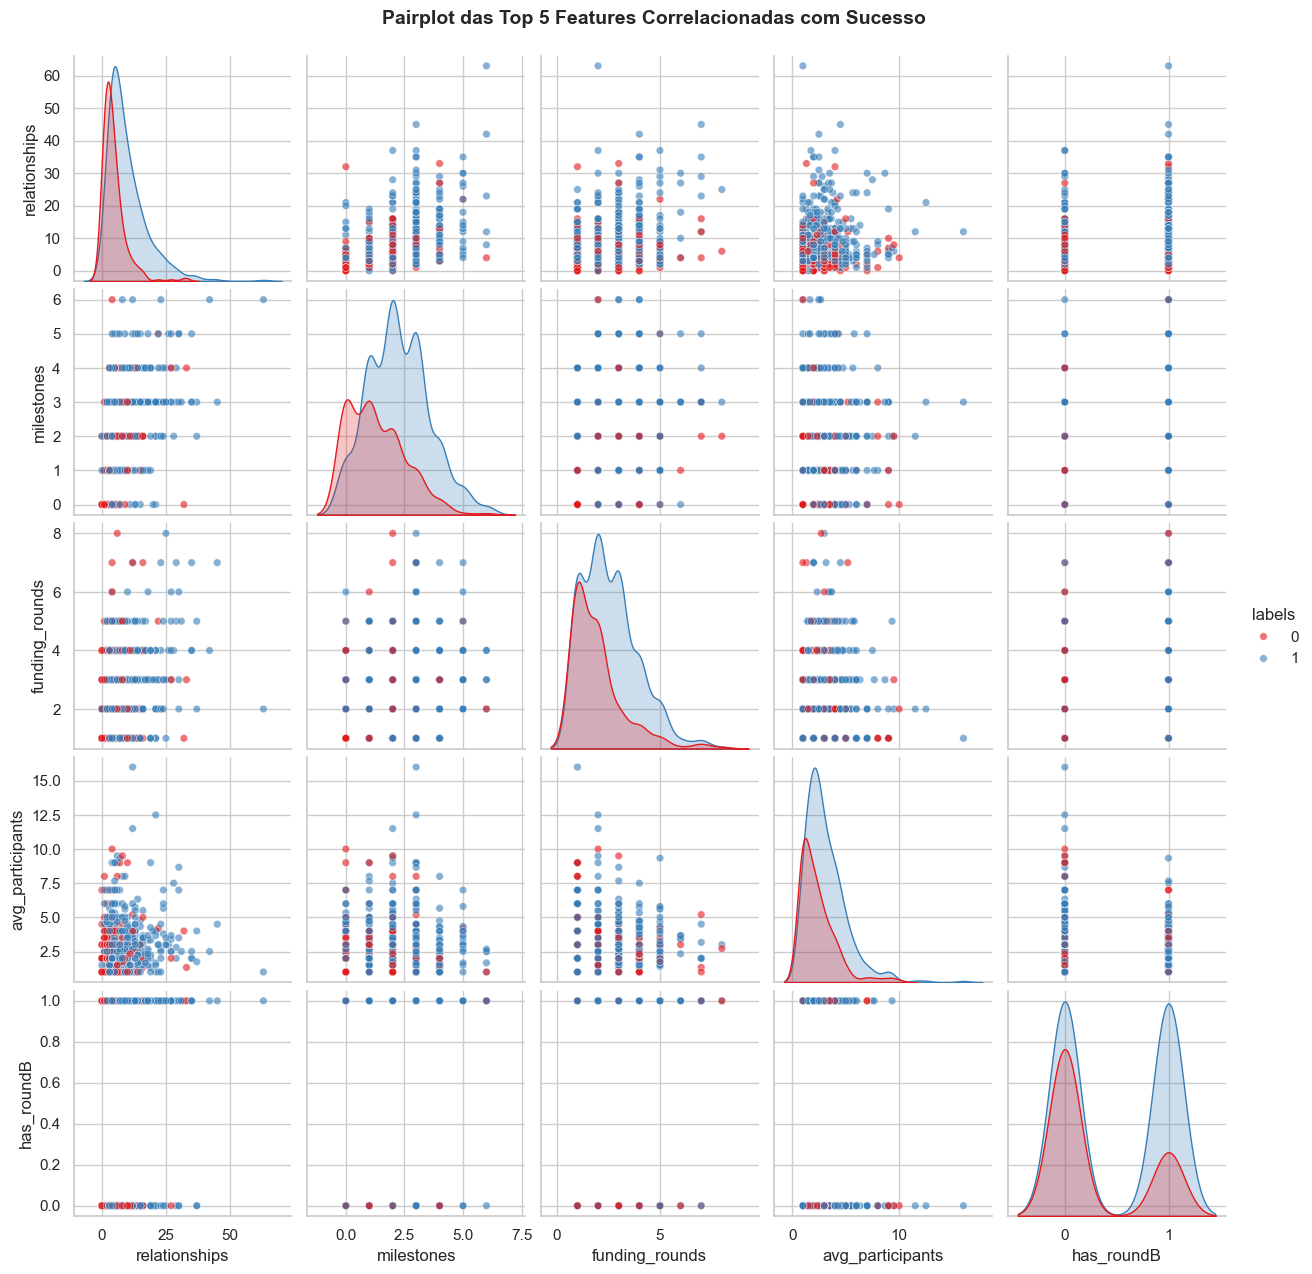

In [21]:
# Pairplot das features mais correlacionadas com o target
top_features_for_pairplot = ['relationships', 'milestones', 'funding_rounds', 
                              'avg_participants', 'has_roundB', TARGET]

print("=" * 80)
print("PAIRPLOT DAS FEATURES MAIS IMPORTANTES")
print("=" * 80)

# Criar subset para pairplot
df_pairplot = df_train[top_features_for_pairplot].copy()

# Pairplot
pairplot_fig = sns.pairplot(df_pairplot, hue=TARGET, palette="Set1", 
                             diag_kind='kde', plot_kws={'alpha': 0.6, 's': 30},
                             corner=False, height=2.5)
pairplot_fig.fig.suptitle('Pairplot das Top 5 Features Correlacionadas com Sucesso', 
                          fontsize=14, fontweight='bold', y=1.02)
plt.show()


### 1.19 Heatmap de Correlação das Top Features


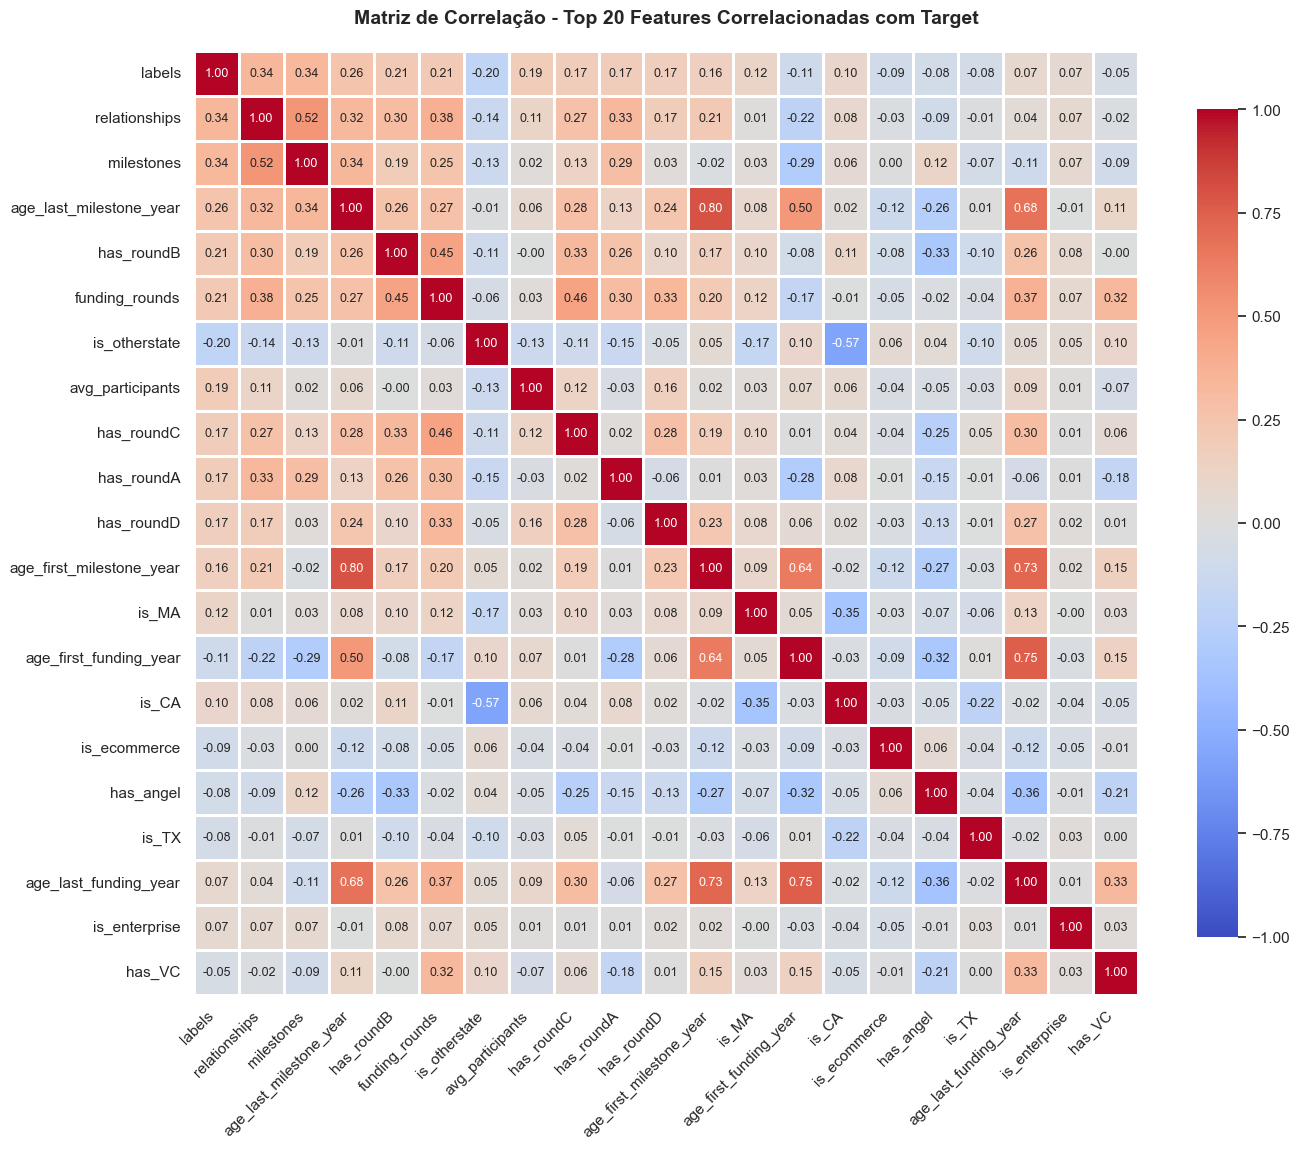


TOP 20 FEATURES MAIS CORRELACIONADAS COM O TARGET
labels                      1.000000
relationships               0.342841
milestones                  0.335149
age_last_milestone_year     0.257261
has_roundB                  0.214299
funding_rounds              0.212760
is_otherstate               0.198638
avg_participants            0.194482
has_roundC                  0.172943
has_roundA                  0.171953
has_roundD                  0.166680
age_first_milestone_year    0.156837
is_MA                       0.116638
age_first_funding_year      0.107239
is_CA                       0.101427
is_ecommerce                0.092407
has_angel                   0.079055
is_TX                       0.077574
age_last_funding_year       0.074744
is_enterprise               0.067350
has_VC                      0.053907


In [22]:
# Heatmap focado nas top 20 features mais correlacionadas com o target
top_20_features = correlation_matrix[TARGET].abs().nlargest(21).index.tolist()  # 20 + target
top_20_corr = df_train[top_20_features].corr()

fig, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(top_20_corr, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=ax,
            vmin=-1, vmax=1, annot_kws={'fontsize': 9})
ax.set_title('Matriz de Correlação - Top 20 Features Correlacionadas com Target', 
             fontsize=14, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("\n" + "=" * 80)
print("TOP 20 FEATURES MAIS CORRELACIONADAS COM O TARGET")
print("=" * 80)
print(correlation_matrix[TARGET].abs().nlargest(21).to_string())


### 1.20 Análise Temporal (Age Features)


ANÁLISE TEMPORAL - AGE FEATURES


C:\Users\Inteli\AppData\Local\Temp\ipykernel_24168\4032762082.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[idx].boxplot(data_to_plot, labels=['Falha (0)', 'Sucesso (1)'],
C:\Users\Inteli\AppData\Local\Temp\ipykernel_24168\4032762082.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[idx].boxplot(data_to_plot, labels=['Falha (0)', 'Sucesso (1)'],
C:\Users\Inteli\AppData\Local\Temp\ipykernel_24168\4032762082.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[idx].boxplot(data_to_plot, labels=['Falha (0)', 'Sucesso (1)'],
C:\Users\Inteli\AppData\Local\Temp\ipykernel_24168\4032762

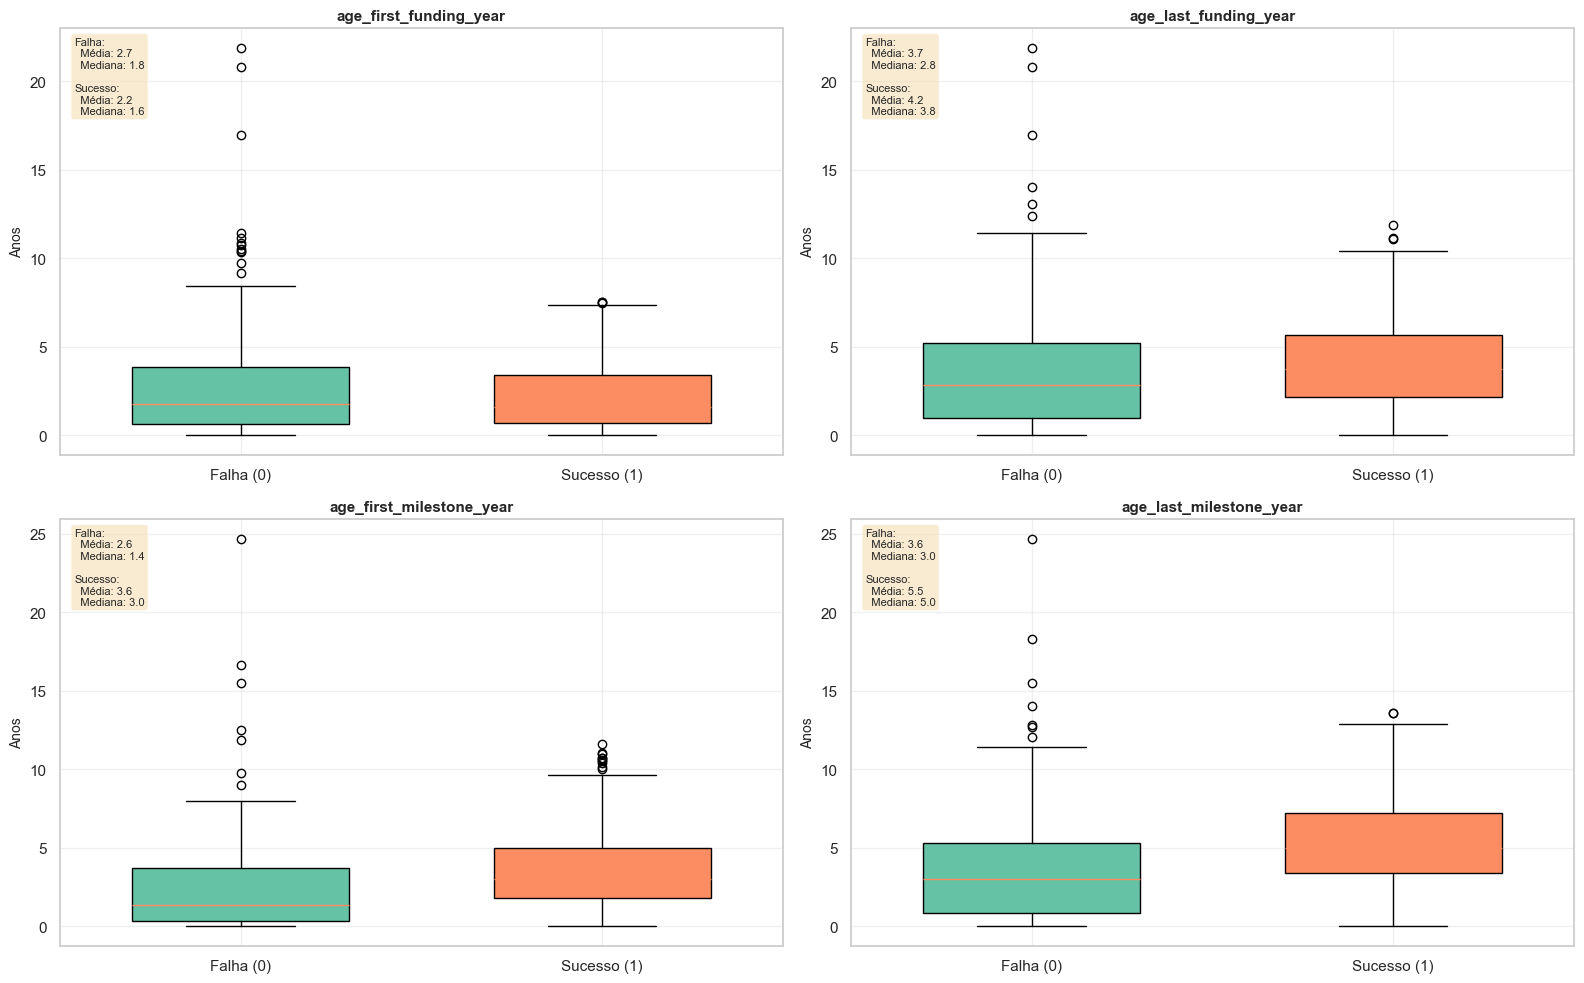

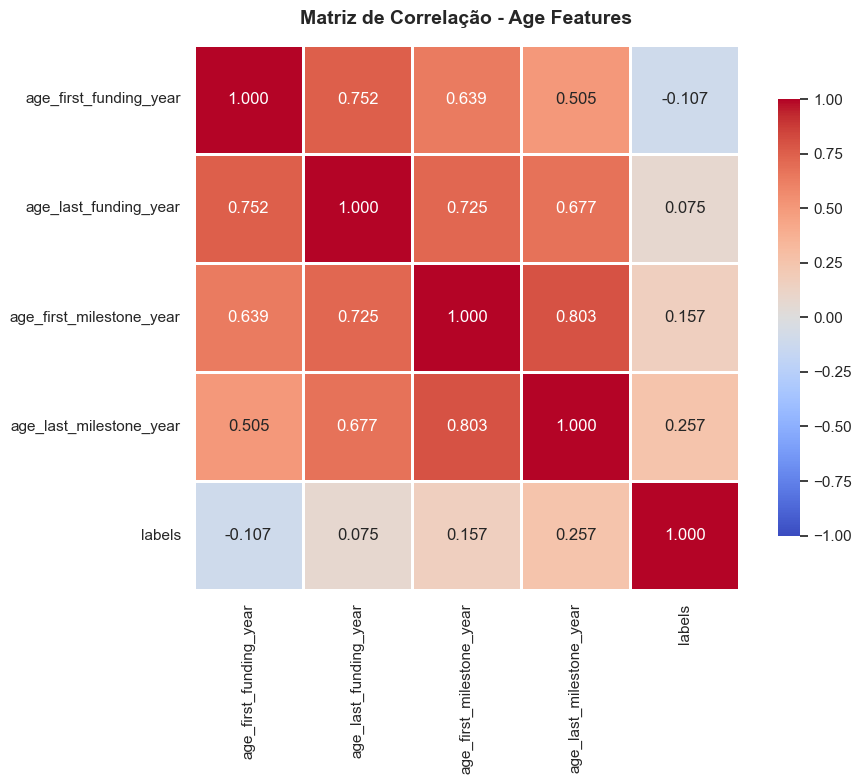

In [23]:
# Análise das features temporais (age)
age_features = ['age_first_funding_year', 'age_last_funding_year', 
                'age_first_milestone_year', 'age_last_milestone_year']

print("=" * 80)
print("ANÁLISE TEMPORAL - AGE FEATURES")
print("=" * 80)

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.ravel()

for idx, col in enumerate(age_features):
    if col in df_train.columns:
        # Boxplot por classe
        data_to_plot = [df_train[df_train[TARGET] == 0][col].dropna(), 
                        df_train[df_train[TARGET] == 1][col].dropna()]
        bp = axes[idx].boxplot(data_to_plot, labels=['Falha (0)', 'Sucesso (1)'], 
                               patch_artist=True, widths=0.6)
        
        # Colorir boxplots
        for patch, color in zip(bp['boxes'], [CUSTOM_PALETTE[0], CUSTOM_PALETTE[1]]):
            patch.set_facecolor(color)
        
        axes[idx].set_title(f'{col}', fontsize=11, fontweight='bold')
        axes[idx].set_ylabel('Anos', fontsize=10)
        axes[idx].grid(alpha=0.3)
        
        # Adicionar estatísticas
        mean_0 = df_train[df_train[TARGET] == 0][col].mean()
        mean_1 = df_train[df_train[TARGET] == 1][col].mean()
        median_0 = df_train[df_train[TARGET] == 0][col].median()
        median_1 = df_train[df_train[TARGET] == 1][col].median()
        
        stats_text = f'Falha:\n  Média: {mean_0:.1f}\n  Mediana: {median_0:.1f}\n\nSucesso:\n  Média: {mean_1:.1f}\n  Mediana: {median_1:.1f}'
        axes[idx].text(0.02, 0.98, stats_text, transform=axes[idx].transAxes, 
                      verticalalignment='top',
                      bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.6), 
                      fontsize=8)

plt.tight_layout()
plt.show()

# Correlações entre age features
if all(col in df_train.columns for col in age_features):
    age_corr = df_train[age_features + [TARGET]].corr()
    
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(age_corr, annot=True, fmt='.3f', cmap='coolwarm', center=0, 
                square=True, linewidths=2, cbar_kws={"shrink": 0.8}, ax=ax,
                vmin=-1, vmax=1)
    ax.set_title('Matriz de Correlação - Age Features', fontsize=14, fontweight='bold', pad=15)
    plt.tight_layout()
    plt.show()


### 1.21 Análise Multivariada: Interações entre Features


ANÁLISE DE INTERAÇÕES ENTRE FEATURES


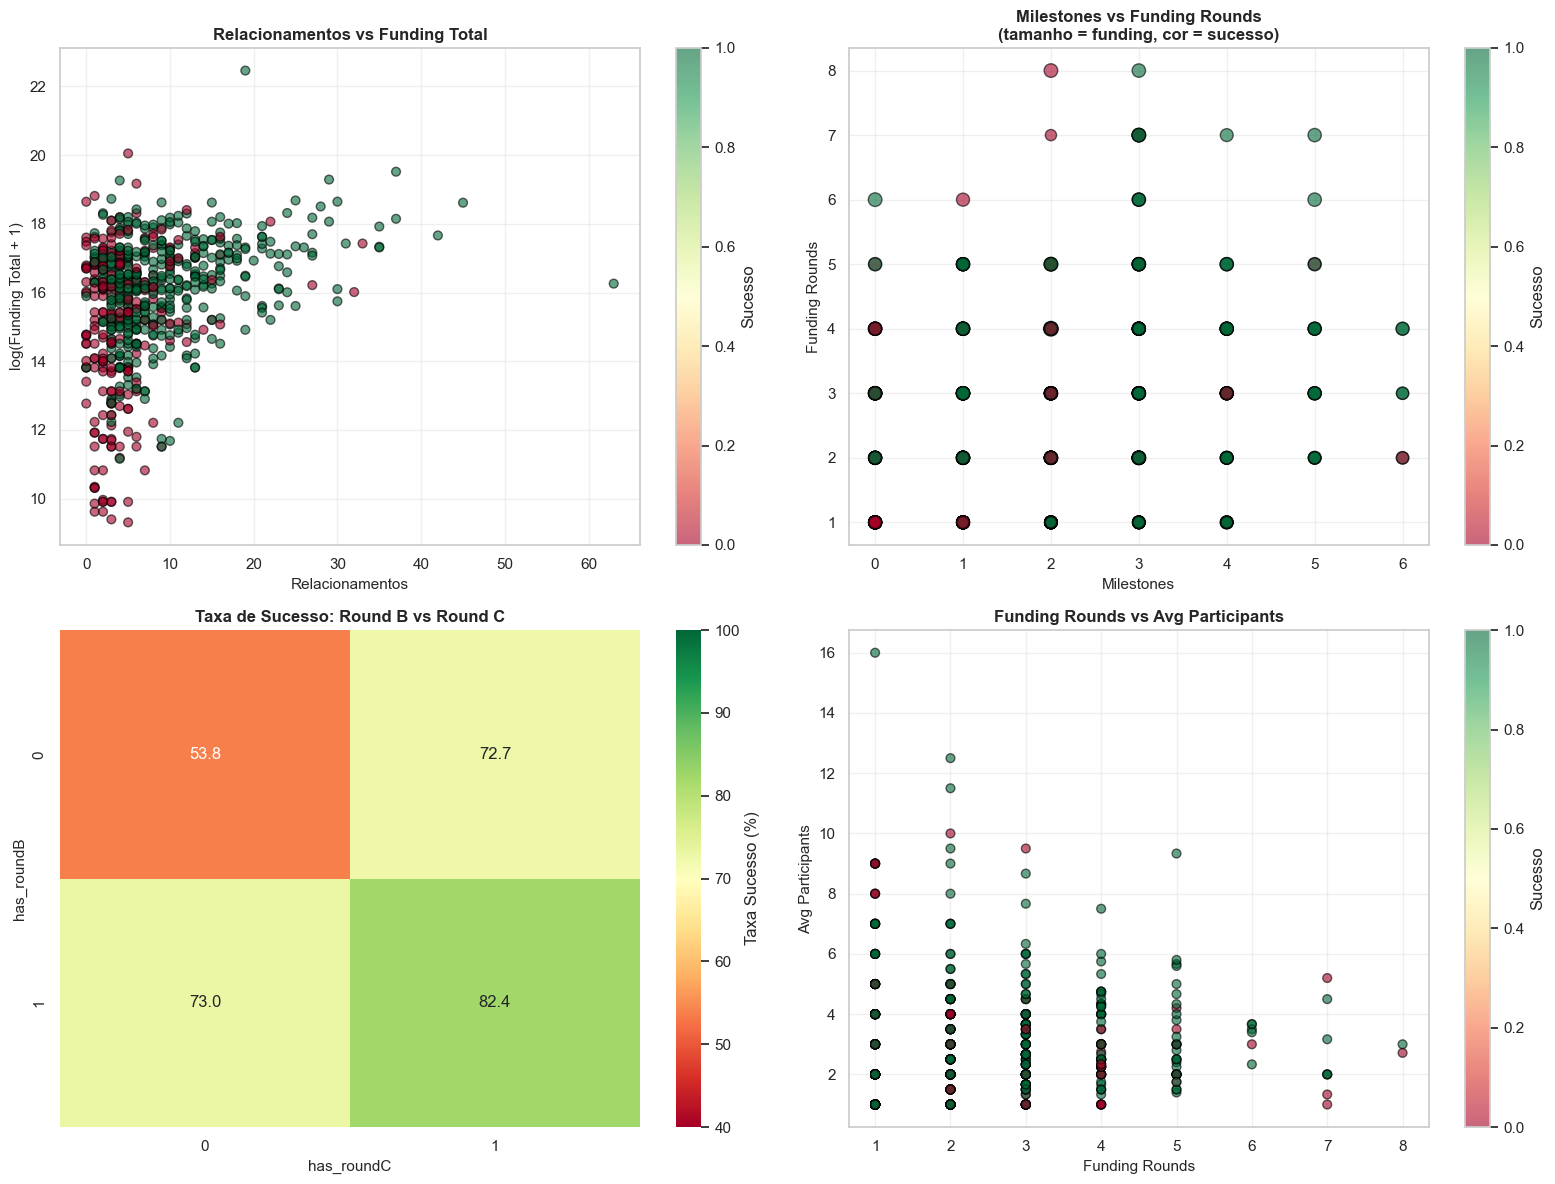

In [24]:
# Análise de interações entre features importantes
print("=" * 80)
print("ANÁLISE DE INTERAÇÕES ENTRE FEATURES")
print("=" * 80)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Relationships vs Funding (colorido por sucesso)
scatter1 = axes[0, 0].scatter(df_train['relationships'], 
                              np.log1p(df_train['funding_total_usd']),
                              c=df_train[TARGET], cmap='RdYlGn', alpha=0.6, 
                              edgecolors='black', s=40)
axes[0, 0].set_xlabel('Relacionamentos', fontsize=11)
axes[0, 0].set_ylabel('log(Funding Total + 1)', fontsize=11)
axes[0, 0].set_title('Relacionamentos vs Funding Total', fontsize=12, fontweight='bold')
axes[0, 0].grid(alpha=0.3)
plt.colorbar(scatter1, ax=axes[0, 0], label='Sucesso')

# 2. Milestones vs Funding Rounds (tamanho = funding, cor = sucesso)
scatter2 = axes[0, 1].scatter(df_train['milestones'], df_train['funding_rounds'],
                              s=np.log1p(df_train['funding_total_usd'])*5,
                              c=df_train[TARGET], cmap='RdYlGn', alpha=0.6, 
                              edgecolors='black')
axes[0, 1].set_xlabel('Milestones', fontsize=11)
axes[0, 1].set_ylabel('Funding Rounds', fontsize=11)
axes[0, 1].set_title('Milestones vs Funding Rounds\n(tamanho = funding, cor = sucesso)', 
                     fontsize=12, fontweight='bold')
axes[0, 1].grid(alpha=0.3)
plt.colorbar(scatter2, ax=axes[0, 1], label='Sucesso')

# 3. Heatmap: Taxa de sucesso por combinação de has_roundB e has_roundC
if 'has_roundB' in df_train.columns and 'has_roundC' in df_train.columns:
    cross_tab = pd.crosstab(df_train['has_roundB'], df_train['has_roundC'], 
                            df_train[TARGET], aggfunc='mean') * 100
    sns.heatmap(cross_tab, annot=True, fmt='.1f', cmap='RdYlGn', ax=axes[1, 0],
                cbar_kws={'label': 'Taxa Sucesso (%)'}, vmin=40, vmax=100)
    axes[1, 0].set_xlabel('has_roundC', fontsize=11)
    axes[1, 0].set_ylabel('has_roundB', fontsize=11)
    axes[1, 0].set_title('Taxa de Sucesso: Round B vs Round C', fontsize=12, fontweight='bold')

# 4. Avg_participants vs Funding_rounds (cor = sucesso)
if 'avg_participants' in df_train.columns:
    scatter4 = axes[1, 1].scatter(df_train['funding_rounds'], 
                                  df_train['avg_participants'],
                                  c=df_train[TARGET], cmap='RdYlGn', alpha=0.6, 
                                  edgecolors='black', s=40)
    axes[1, 1].set_xlabel('Funding Rounds', fontsize=11)
    axes[1, 1].set_ylabel('Avg Participants', fontsize=11)
    axes[1, 1].set_title('Funding Rounds vs Avg Participants', fontsize=12, fontweight='bold')
    axes[1, 1].grid(alpha=0.3)
    plt.colorbar(scatter4, ax=axes[1, 1], label='Sucesso')

plt.tight_layout()
plt.show()


### 1.22 Resumo Estatístico Comparativo: Sucesso vs Falha


COMPARAÇÃO ESTATÍSTICA: STARTUPS DE SUCESSO vs FALHA

                 Feature  Falha_Media  Sucesso_Media  Diferenca_%  Falha_Mediana  Sucesso_Mediana    Falha_Std  Sucesso_Std
       funding_total_usd 1.613087e+07   3.678658e+07   128.050730    5000000.000     13000000.000 4.088613e+07 2.794303e+08
           relationships 4.517544e+00   9.820574e+00   117.387467          3.000            7.000 4.762616e+00 7.896140e+00
              milestones 1.307018e+00   2.244019e+00    71.690055          1.000            2.000 1.206642e+00 1.289238e+00
 age_last_milestone_year 3.639739e+00   5.467408e+00    50.214316          3.020            5.015 3.711986e+00 2.831429e+00
age_first_milestone_year 2.638472e+00   3.635192e+00    37.776410          1.370            3.015 3.486450e+00 2.531631e+00
        avg_participants 2.350282e+00   3.120496e+00    32.771142          2.000            2.500 1.691840e+00 1.944447e+00
          funding_rounds 1.960526e+00   2.564593e+00    30.811470          2.0

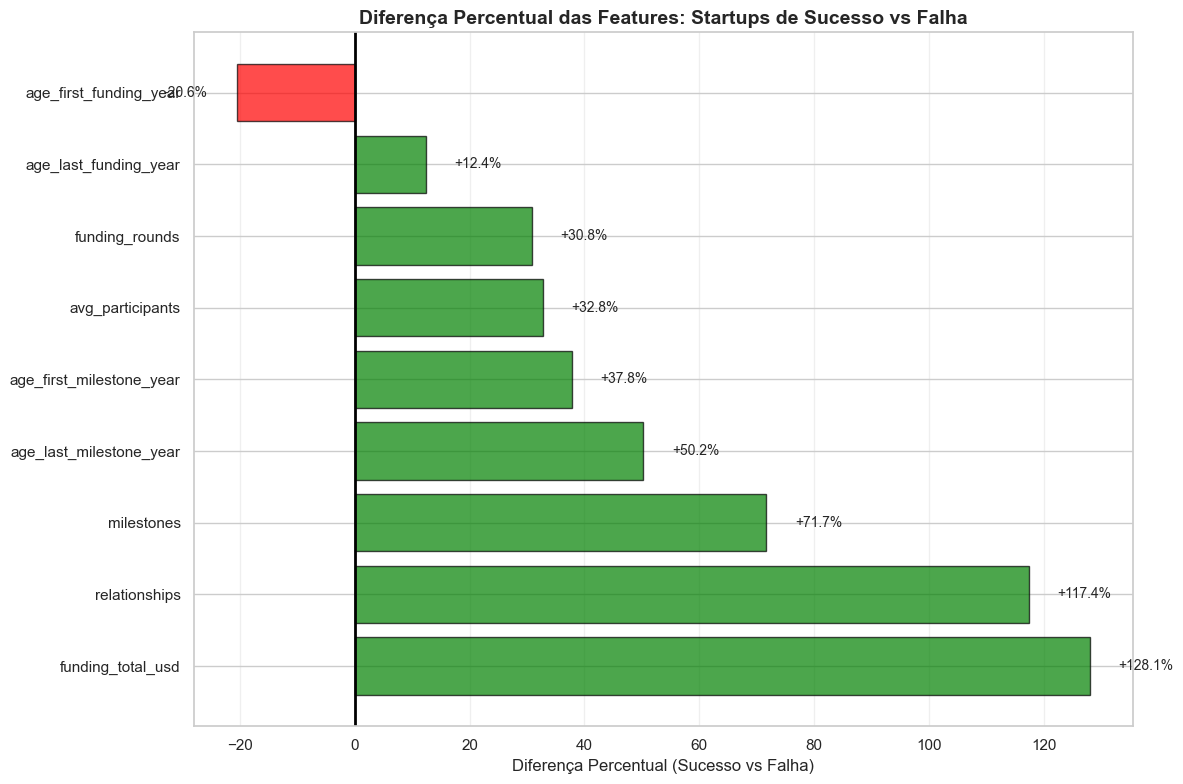

In [25]:
# Comparação estatística detalhada entre sucesso e falha
print("=" * 100)
print("COMPARAÇÃO ESTATÍSTICA: STARTUPS DE SUCESSO vs FALHA")
print("=" * 100)

# Selecionar features numéricas principais para comparação
main_num_features = ['relationships', 'funding_rounds', 'funding_total_usd', 'milestones',
                     'avg_participants', 'age_first_funding_year', 'age_last_funding_year',
                     'age_first_milestone_year', 'age_last_milestone_year']

comparison_df = pd.DataFrame()

for feature in main_num_features:
    if feature in df_train.columns:
        fail_data = df_train[df_train[TARGET] == 0][feature]
        success_data = df_train[df_train[TARGET] == 1][feature]
        
        comparison_df = pd.concat([comparison_df, pd.DataFrame({
            'Feature': [feature],
            'Falha_Media': [fail_data.mean()],
            'Sucesso_Media': [success_data.mean()],
            'Diferenca_%': [(success_data.mean() - fail_data.mean()) / fail_data.mean() * 100 if fail_data.mean() != 0 else 0],
            'Falha_Mediana': [fail_data.median()],
            'Sucesso_Mediana': [success_data.median()],
            'Falha_Std': [fail_data.std()],
            'Sucesso_Std': [success_data.std()]
        })], ignore_index=True)

comparison_df = comparison_df.sort_values('Diferenca_%', ascending=False)
print("\n" + comparison_df.to_string(index=False))

# Visualização das diferenças
fig, ax = plt.subplots(figsize=(12, 8))
colors = ['green' if x > 0 else 'red' for x in comparison_df['Diferenca_%']]
bars = ax.barh(comparison_df['Feature'], comparison_df['Diferenca_%'], color=colors, 
               edgecolor='black', alpha=0.7)
ax.set_xlabel('Diferença Percentual (Sucesso vs Falha)', fontsize=12)
ax.set_title('Diferença Percentual das Features: Startups de Sucesso vs Falha', 
             fontsize=14, fontweight='bold')
ax.axvline(0, color='black', linewidth=2)
ax.grid(axis='x', alpha=0.3)

# Adicionar valores
for i, (bar, val) in enumerate(zip(bars, comparison_df['Diferenca_%'])):
    ax.text(val + (5 if val > 0 else -5), bar.get_y() + bar.get_height()/2, 
            f'{val:+.1f}%', va='center', ha='left' if val > 0 else 'right', fontsize=10)

plt.tight_layout()
plt.show()


### 1.12 Hipóteses de Negócio

Com base na análise exploratória, podemos formular as seguintes hipóteses:

1. **Capital e Rodadas de Funding**: Startups com maior número de rodadas e maior total captado tendem a ter maior chance de sucesso (`funding_rounds`, `funding_total_usd`).

2. **Momentum e Milestones**: Startups com milestones em anos próximos têm maior momentum e chance de sucesso (`age_first_milestone_year`, `age_last_milestone_year`).

3. **Relacionamentos e Network**: O número de relacionamentos (`relationships`) e milestones (`milestones`) mostram forte correlação positiva com sucesso, indicando que networking é crucial.

4. **Localização e Setor**: Setores e localização influenciam (e.g., `is_CA`, `is_NY`, `category_code`), assim como presença de rodadas específicas (`has_roundB`, `has_roundC`).

5. **Maturidade**: A presença de rodadas mais avançadas (B, C, D) indica maior maturidade e validação de mercado.


---

## 2. Engenharia de Features


In [26]:
# Engenharia de features adicionais úteis

def add_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    # Conversões simples: tratar funding_total_usd em log para reduzir cauda longa
    if 'funding_total_usd' in df.columns:
        df['funding_total_usd_log'] = np.log1p(df['funding_total_usd'])
    # Durações aproximadas entre primeiro e último funding/milestone
    if {'age_first_funding_year','age_last_funding_year'}.issubset(df.columns):
        df['funding_span'] = (df['age_last_funding_year'] - df['age_first_funding_year']).fillna(0)
    if {'age_first_milestone_year','age_last_milestone_year'}.issubset(df.columns):
        df['milestone_span'] = (df['age_last_milestone_year'] - df['age_first_milestone_year']).fillna(0)
    # Interações simples
    if {'funding_rounds','avg_participants'}.issubset(df.columns):
        df['rounds_x_participants'] = df['funding_rounds'] * df['avg_participants'].fillna(0)
    # Binários resumidos
    vc_flags = [c for c in df.columns if c.startswith('has_')]
    if vc_flags:
        df['has_any_round'] = df[vc_flags].sum(axis=1)
    # Categoria reduzida: top categorias mantidas, outras como 'other_cat'
    if 'category_code' in df.columns:
        top_cats = df['category_code'].value_counts().nlargest(8).index
        df['category_code_reduced'] = np.where(df['category_code'].isin(top_cats), df['category_code'], 'other_cat')
    return df

X_fe = add_features(X)
X_test_fe = add_features(df_test)

# Atualizar listas de colunas
num_cols = X_fe.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X_fe.columns if c not in num_cols]

# Remover identificador
if 'id' in num_cols:
    num_cols.remove('id')
if 'id' in cat_cols:
    cat_cols.remove('id')

print(f"Features após engenharia:")
print(f"  - Numéricas: {len(num_cols)}")
print(f"  - Categóricas: {len(cat_cols)}")
print(f"  - Total: {len(num_cols) + len(cat_cols)}")


Features após engenharia:
  - Numéricas: 35
  - Categóricas: 2
  - Total: 37


---

## 3. Pré-processamento


**Estratégias:**
- **Numéricas**: imputação por mediana e padronização (`StandardScaler`)
- **Categóricas**: imputação por moda e `OneHotEncoder` com `handle_unknown='ignore'`
- **Validação**: Split estratificado 80/20 para avaliação final (holdout)


In [27]:
# Pré-processamento: imputação, codificação, padronização
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=True))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ], remainder="drop"
)

# Split estratificado com holdout para avaliação final
X_train, X_valid, y_train, y_valid = train_test_split(
    X_fe, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Conjunto de treino: {X_train.shape}")
print(f"Conjunto de validação: {X_valid.shape}")


Conjunto de treino: (516, 38)
Conjunto de validação: (130, 38)


---

## 4. Modelagem


### 4.1 Benchmark de Modelos

Avaliamos diferentes classificadores via validação cruzada estratificada (5-fold):


In [28]:
# Compatibilidade com scikit-learn >= 1.2: usar sparse_output em vez de sparse
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ], remainder="drop"
)

print("Preprocessor configurado com sucesso!")


Preprocessor configurado com sucesso!


### 4.2 Seleção de Candidatos

Ordenamos as médias de acurácia dos modelos no CV e escolhemos os três melhores para ajuste fino.


### 4.3 Ajuste de Hiperparâmetros (GridSearchCV)

Executamos busca de hiperparâmetros com validação cruzada para os top 3 candidatos.


### 4.4 Avaliação no Holdout

Com o melhor modelo, avaliamos no conjunto de validação. Ajustamos threshold para otimizar acurácia.


In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

models = {
    "logreg": LogisticRegression(max_iter=200, n_jobs=None),
    "rf": RandomForestClassifier(n_estimators=400, random_state=42),
    "gb": GradientBoostingClassifier(random_state=42),
    "svc_rbf": SVC(kernel="rbf", probability=True, random_state=42),
    "knn": KNeighborsClassifier(n_neighbors=15)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = {}

for name, clf in models.items():
    pipe = Pipeline(steps=[("pre", preprocessor), ("clf", clf)])
    scores = cross_val_score(pipe, X_fe, y, cv=cv, scoring="accuracy", n_jobs=None)
    results[name] = (scores.mean(), scores.std())

pd.Series({k: v[0] for k,v in results.items()}).sort_values(ascending=False)


c:\Users\Inteli\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] O sistema não pode encontrar o arquivo especificado
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Inteli\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "c:\Users\Inteli\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 556, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Inteli\AppData\Local\Programs\Python\Python313\Lib\subprocess.

gb         0.787895
rf         0.783268
logreg     0.750757
svc_rbf    0.747668
knn        0.698163
dtype: float64

In [30]:
# Selecionar melhores candidatos pela média de CV
cv_means = pd.Series({k: v[0] for k,v in results.items()}).sort_values(ascending=False)
print(cv_means)

best_names = cv_means.index[:3].tolist()
print("Top candidatos para tuning:", best_names)



gb         0.787895
rf         0.783268
logreg     0.750757
svc_rbf    0.747668
knn        0.698163
dtype: float64
Top candidatos para tuning: ['gb', 'rf', 'logreg']


In [31]:
# GridSearch nos melhores modelos
param_grids = {
    "logreg": {
        "clf__solver": ["liblinear", "lbfgs"],
        "clf__C": [0.1, 1.0, 3.0, 10.0],
        "clf__penalty": ["l2"],
        "clf__max_iter": [300]
    },
    "rf": {
        "clf__n_estimators": [300, 600, 900],
        "clf__max_depth": [None, 6, 10, 16],
        "clf__min_samples_split": [2, 5, 10],
        "clf__min_samples_leaf": [1, 2, 4]
    },
    "gb": {
        "clf__n_estimators": [150, 300],
        "clf__learning_rate": [0.03, 0.06, 0.1],
        "clf__max_depth": [2, 3],
        "clf__subsample": [0.7, 1.0]
    },
    "svc_rbf": {
        "clf__C": [0.5, 1, 3, 10],
        "clf__gamma": ["scale", 0.05, 0.1]
    }
}

best_overall = None
best_score = -np.inf
best_estimator = None
best_name = None

for name in best_names:
    if name not in param_grids:
        continue
    base = models[name]
    pipe = Pipeline(steps=[("pre", preprocessor), ("clf", base)])
    gcv = GridSearchCV(
        estimator=pipe,
        param_grid=param_grids[name],
        scoring="accuracy",
        cv=cv,
        n_jobs=None,
        refit=True,
        verbose=0
    )
    gcv.fit(X_train, y_train)
    print(f"{name} best CV accuracy: {gcv.best_score_:.4f}")
    if gcv.best_score_ > best_score:
        best_score = gcv.best_score_
        best_overall = gcv
        best_estimator = gcv.best_estimator_
        best_name = name

print("Melhor modelo:", best_name)
print("Best params:", best_overall.best_params_)


gb best CV accuracy: 0.8004
rf best CV accuracy: 0.8063
logreg best CV accuracy: 0.7519
Melhor modelo: rf
Best params: {'clf__max_depth': 10, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 300}


Melhor threshold no holdout: 0.55 | acc: 0.7692

MÉTRICAS NO CONJUNTO DE VALIDAÇÃO (HOLDOUT)
Acurácia: 0.7692

              precision    recall  f1-score   support

           0     0.7105    0.5870    0.6429        46
           1     0.7935    0.8690    0.8295        84

    accuracy                         0.7692       130
   macro avg     0.7520    0.7280    0.7362       130
weighted avg     0.7641    0.7692    0.7635       130



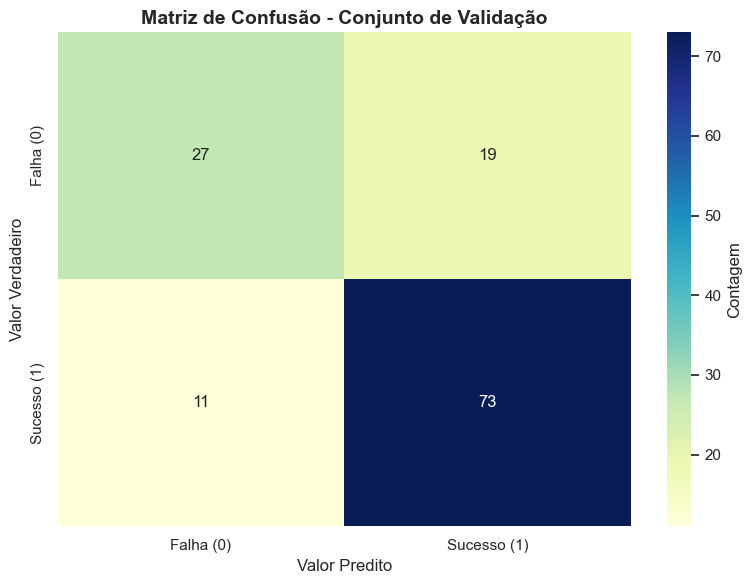

In [32]:
# Avaliação no holdout
best_estimator.fit(X_train, y_train)
proba_valid = None
if hasattr(best_estimator.named_steps['clf'], "predict_proba"):
    proba_valid = best_estimator.predict_proba(X_valid)[:, 1]
    # threshold tuning simples
    thresholds = np.linspace(0.3, 0.7, 9)
    accs = []
    for t in thresholds:
        preds_t = (proba_valid >= t).astype(int)
        accs.append((t, accuracy_score(y_valid, preds_t)))
    best_t, best_acc = max(accs, key=lambda x: x[1])
    print(f"Melhor threshold no holdout: {best_t:.2f} | acc: {best_acc:.4f}")
    y_pred = (proba_valid >= best_t).astype(int)
else:
    y_pred = best_estimator.predict(X_valid)

print("\n" + "=" * 60)
print("MÉTRICAS NO CONJUNTO DE VALIDAÇÃO (HOLDOUT)")
print("=" * 60)
print(f"Acurácia: {accuracy_score(y_valid, y_pred):.4f}")
print("\n" + classification_report(y_valid, y_pred, digits=4))

# Matriz de confusão melhorada
cm = confusion_matrix(y_valid, y_pred)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', ax=ax, 
            xticklabels=['Falha (0)', 'Sucesso (1)'], 
            yticklabels=['Falha (0)', 'Sucesso (1)'],
            cbar_kws={'label': 'Contagem'})
ax.set_title('Matriz de Confusão - Conjunto de Validação', fontsize=14, fontweight='bold')
ax.set_ylabel('Valor Verdadeiro', fontsize=12)
ax.set_xlabel('Valor Predito', fontsize=12)
plt.tight_layout()
plt.show()

best_threshold = None
if proba_valid is not None:
    best_threshold = best_t


---

## 5. Treino Final e Submissão

Treinamos o melhor `Pipeline` em 100% dos dados de treino e geramos as previsões para o conjunto de teste.


In [33]:
# Treinar modelo final no dataset completo e gerar submissão
final_model = best_overall.best_estimator_
final_model.fit(X_fe, y)

# Predições no teste
if hasattr(final_model.named_steps['clf'], "predict_proba") and best_threshold is not None:
    test_proba = final_model.predict_proba(X_test_fe)[:, 1]
    test_pred = (test_proba >= best_threshold).astype(int)
else:
    test_pred = final_model.predict(X_test_fe)

submission = pd.DataFrame({
    "id": df_test[ID],
    "labels": test_pred
})
submission.to_csv("submission.csv", index=False)
submission.head()


,id,labels
0,70,1
1,23,0
2,389,1
3,872,1
4,920,1


---

## 6. Considerações Finais

**Pipeline Implementado:**
- Análise exploratória completa com matriz de correlação e visualizações
- Imputação, padronização e one-hot encoding
- Engenharia de features: `funding_total_usd_log`, `funding_span`, `milestone_span`, `rounds_x_participants`, `has_any_round`, `category_code_reduced`
- Benchmark com validação cruzada 5-fold
- Tuning de hiperparâmetros via GridSearchCV
- Otimização de threshold para probabilidades
- Avaliação completa no holdout

**Arquivo `submission.csv` gerado com sucesso!**


## 7. Insights e Conclusões

**Principais Descobertas da EDA:**

1. **Relacionamentos são cruciais**: A feature `relationships` apresenta a maior correlação com sucesso (0.34), indicando que networking é fundamental para startups.

2. **Milestones como indicador**: Tanto a quantidade de milestones quanto o timing (age_last_milestone_year) são fortemente correlacionados com sucesso.

3. **Importância das rodadas avançadas**: As features `has_roundB`, `has_roundC` e `has_roundD` mostram correlação positiva, indicando que startups que chegam a rodadas mais avançadas têm maior probabilidade de sucesso.

4. **Desbalanceamento moderado**: O dataset apresenta aproximadamente 65% de casos de sucesso vs 35% de falha, o que justifica o uso de estratificação.

5. **Missing values concentrados**: As features relacionadas a milestones apresentam ~20% de valores ausentes, o que pode indicar startups em estágios mais iniciais.

6. **Variação por setor**: Diferentes categorias de startups apresentam taxas de sucesso distintas, com alguns setores tendo performance superior.
